# ICA 2D Demo


# Imports:

In [1]:
import numpy as np
import argparse
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

# Input arguments:

In [2]:
parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.add_argument('--batch_size', type=int, default=128,  help='Batch size (default=128)')
parser.add_argument('--hidden_dim', type=int, default=64,  help='Hidden layer size')
parser.add_argument('--beta', type=float, default=5e-2,  help='independence loss coefficient')
parser.add_argument('--lr', type=float, default=1e-4,  help='learning_rate (default=1e-3)')
parser.add_argument("--min_lr",  type=float,  default=1e-5,  help="Minimal learning rate")
parser.add_argument("--decay_step_size",  type=int,  default=100,  help="LR decay step size")
parser.add_argument("--lr_decay_factor",  type=float,  default=0.1,  help="LR decay factor")
parser.add_argument("--drop_prob",  type=float,  default=.0,  help="Dropout probability")
parser.add_argument("--weight_decay",  type=float,  default=1e-2,  help="l_2 weight penalty")
parser.add_argument("--n_epochs",  type=int,  default=1000,  help="Number of epochs without improvement before stopping")
parser.add_argument("--mixing",  type=str,  default='nonlinear',  help="linear | nonlinear")

FLAGS = parser.parse_args(args=[])

if FLAGS.mixing == 'linear':
    ACTIVATION = nn.Identity()
else:
    ACTIVATION = nn.Softplus()

device = torch.device("cpu")

# Datasets
Latent data is generated from uniform distribution on the unit square. We observe the data via two views, 
where each view is obtained by a matrix multiplication of the latent coordinates.

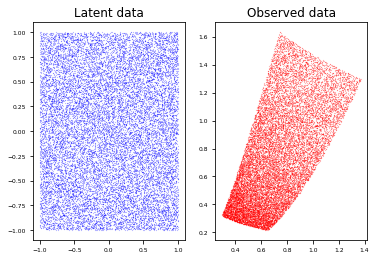

In [3]:
n = 20000
# create latent data
U = np.random.rand(n, 2) * 2 - 1
cond = U[:, 0]
target = U[:, 1]

# mixing matrix
A = np.random.rand(2, 2) * 2 - 1 + np.identity(2) * 1

# observed data
X = np.matmul(U,A)
X = ACTIVATION(torch.tensor(X)).numpy()

y = np.expand_dims(cond, 1)

# Standardize samples
scaler = StandardScaler()
#X = scaler.fit_transform(X)

fig, axs = plt.subplots(1, 2)
axs[0].plot(cond, target, 'o', color='blue', markersize=.1)
axs[0].set_title('Latent data', size=12)
axs[0].tick_params(axis='both', which='major', labelsize=6)
axs[1].plot(X[:, 0], X[:, 1], 'o', color='red', markersize=.1)
axs[1].set_title('Observed data', size=12)
axs[1].tick_params(axis='both', which='major', labelsize=6)

input_dim = X.shape[1]

train_x, test_x, train_y, test_y = train_test_split(X, 
                                                    y, 
                                                    test_size=0.15)
train_x, val_x , train_y, val_y = train_test_split(train_x, 
                                                   train_y, 
                                                   test_size=0.1)

train_data = TensorDataset(torch.from_numpy(train_x).float(), torch.from_numpy(train_y).float())
val_data = TensorDataset(torch.from_numpy(val_x).float(), torch.from_numpy(val_y).float())
test_data = TensorDataset(torch.from_numpy(test_x).float(), torch.from_numpy(test_y).float())
        
train_loader = DataLoader(train_data, shuffle=True, batch_size=FLAGS.batch_size)
val_loader = DataLoader(val_data, shuffle=False, batch_size=FLAGS.batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=FLAGS.batch_size)   

# Models

In [4]:
class Encoder(nn.Module):   
    def __init__(self, 
                 input_dim, 
                 hidden_dim, 
                 drop_prob=0.5,
                 norm_layer=nn.BatchNorm1d,
                 activation=ACTIVATION):
        
        super(Encoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = 64
        self.drop_prob = drop_prob
        self.norm_layer = norm_layer
        self.activation = activation
        
        use_bias = norm_layer != nn.BatchNorm1d
        
         # Layers
        self.layer1 = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim, bias=use_bias),
            self.norm_layer(self.hidden_dim),
            self.activation,
            nn.Dropout(self.drop_prob)
        )

        self.layer2 = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim, bias=use_bias),
            self.norm_layer(self.hidden_dim),
            self.activation,
            nn.Dropout(self.drop_prob)
        )
        
        self.layer3 = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim, bias=use_bias),
            self.norm_layer(self.hidden_dim),
            self.activation,
            nn.Dropout(self.drop_prob)
        )
        
        self.code = nn.Sequential(
            nn.Linear(self.hidden_dim, 1),
            #self.norm_layer(1),
        ) 
               
    def forward(self, x):
        """
        Standard forward
        """
        x = self.layer1(x)
        x = x + self.layer2(x)
        x = x + self.layer3(x)
        code = self.code(x)
        return code
        
class Decoder(nn.Module):   
    def __init__(self, 
                 hidden_dim, 
                 output_dim, 
                 drop_prob=0.5,
                 norm_layer=nn.BatchNorm1d,
                 activation=ACTIVATION,
                 label_embedding_dim=32):
        
        super(Decoder, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = 64
        self.drop_prob = drop_prob
        self.norm_layer = norm_layer
        self.activation = activation
        use_bias = norm_layer != nn.BatchNorm1d
        
         # Layers
        self.layer1 = nn.Sequential(
            nn.Linear(1 + 1, self.hidden_dim, bias=use_bias),
            self.norm_layer(self.hidden_dim),
            self.activation,
            nn.Dropout(self.drop_prob)
        )

        self.layer2 = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim, bias=use_bias),
            self.norm_layer(self.hidden_dim),
            self.activation,
            nn.Dropout(self.drop_prob)
        )
        
        self.layer3 = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim, bias=use_bias),
            self.norm_layer(self.hidden_dim),
            self.activation,
            nn.Dropout(self.drop_prob)
        )
        
        self.recon_layer = nn.Sequential(
            nn.Linear(self.hidden_dim, self.output_dim),
            self.activation
        )    
                
    def forward(self, x, y):
        """
        Concats bio and batch codes, and does forward propagation to obtain recon
        """
        x = torch.cat([x, y], dim=1)
        x = self.layer1(x)
        x = x + self.layer2(x)
        x = x + self.layer3(x)
        recon = self.recon_layer(x)
        return recon

class Ind_discriminator(nn.Module):   
    def __init__(self, 
                 hidden_dim, 
                 drop_prob=0.5,
                 norm_layer=nn.BatchNorm1d,
                 activation=nn.LeakyReLU()):
        
        super(Ind_discriminator, self).__init__()
        self.hidden_dim = hidden_dim
        self.drop_prob = drop_prob
        self.norm_layer = norm_layer
        self.activation = activation
        use_bias = norm_layer != nn.BatchNorm1d
        
         # Layers
        self.layer1 = nn.Sequential(
            nn.Linear(1, self.hidden_dim, bias=use_bias),
            self.norm_layer(self.hidden_dim),
            self.activation,
        )

        self.layer2 = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim, bias=use_bias),
            self.norm_layer(self.hidden_dim),
            self.activation,
        )
        
        self.layer3 = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim, bias=use_bias),
            self.norm_layer(self.hidden_dim),
            self.activation,
        )
        
        self.layer4 = nn.Sequential(
            nn.Linear(self.hidden_dim, 1),
        )

    def forward(self, x, y):
        """
        Concats bio and batch codes, and does forward propagation to obtain recon
        """
        
        x = self.layer1(x)
        x = x + self.layer2(x)
        x = x + self.layer3(x)
        x = self.layer4(x)
        
        mx = torch.mean(x)
        my = torch.mean(y)
        
        xc = x - mx
        yc = y - my
        
        r_square =  (xc * yc).sum() ** 2 / ((xc ** 2).sum() * (yc ** 2).sum())
        return r_square
     
encoder = Encoder(input_dim, 
                  hidden_dim=FLAGS.hidden_dim, 
                  drop_prob=FLAGS.drop_prob)

decoder = Decoder(hidden_dim=FLAGS.hidden_dim,
                  output_dim=input_dim,
                  drop_prob=FLAGS.drop_prob)

ind_discriminator = Ind_discriminator(hidden_dim=16,
                                      drop_prob=FLAGS.drop_prob)
       
encoder.to(device=device)
decoder.to(device=device)
ind_discriminator.to(device=device)

Ind_discriminator(
  (activation): LeakyReLU(negative_slope=0.01)
  (layer1): Sequential(
    (0): Linear(in_features=1, out_features=16, bias=False)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (layer2): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=False)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (layer3): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=False)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (layer4): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
  )
)

# Loss criterions

In [5]:
recon_criterion = nn.L1Loss()

def ind_criterion (r_square, should_be_dependent=True):
    if should_be_dependent:
        return -r_square
    else:
        return r_square
    

def compute_ind_disc_R1_loss(model, x, y):
    x = x.detach().clone()
    x.requires_grad_()
    pred_real = model(x, y).sum()
    grad_real, = torch.autograd.grad(
        outputs=pred_real,
        inputs=[x],
        create_graph=True,
        retain_graph=True,
    )
    grad_real2 = grad_real.pow(2)
    dims = list(range(1, grad_real2.ndim))
    grad_penalty = grad_real2.sum(dims) * 0.5

    return grad_penalty.sum()     
    

 # Optimizers and Learning rates

In [6]:
def lambda_rule(epoch) -> float:
    """ stepwise learning rate calculator """
    exponent = int(np.floor((epoch + 1) / FLAGS.decay_step_size))
    return np.power(FLAGS.lr_decay_factor, exponent)

def update_lr(optim, scheduler):
        """ Learning rate updater """
        
        scheduler.step()
        lr = optim.param_groups[0]['lr']
        if lr < FLAGS.min_lr:
            optim.param_groups[0]['lr'] = FLAGS.min_lr
            lr = optim.param_groups[0]['lr']
        print('Learning rate = %.7f' % lr) 

ae_optim = torch.optim.Adam(list(encoder.parameters()) +\
                            list(decoder.parameters()),
                            betas=(0.0, 0.999),
                            lr=FLAGS.lr, 
                            weight_decay=FLAGS.weight_decay)

ind_disc_optim = torch.optim.Adam(ind_discriminator.parameters(), 
                              lr=FLAGS.lr,
                              betas=(0.0, 0.999),     
                              weight_decay=FLAGS.weight_decay) 

ae_sched = lr_scheduler.LambdaLR(ae_optim, 
                                 lr_lambda=lambda_rule) 

disc_sched = lr_scheduler.LambdaLR(ind_disc_optim, 
                                   lr_lambda=lambda_rule)     


# Sanity checks

In [7]:
for step, (batch_x, batch_y) in enumerate(train_loader):
    break
            
batch_x = batch_x.float().to(device=device)
batch_y = batch_y.to(device=device)

print('batch_x.shape: ', batch_x.shape)
print('batch_y.shape: ', batch_y.shape)
            
# train discriminator
code = encoder(batch_x)
print(code.dtype)

abs_correl = ind_discriminator(code, batch_y) 
indep_loss = abs_correl
discriminator_loss = - abs_correl
print(abs_correl.dtype)

print('discriminator_loss: ', discriminator_loss)
recon = decoder(code, batch_y)
print('recon.min(): ', recon.min())
print('recon.max(): ', recon.max())
print('batch_x.min(): ', batch_x.min())
print('batch_x.max(): ', batch_x.max())
recon_loss = recon_criterion(recon, batch_x)   
discriminator_loss.backward()

print('ok')
  

batch_x.shape:  torch.Size([128, 2])
batch_y.shape:  torch.Size([128, 1])
torch.float32
torch.float32
discriminator_loss:  tensor(-0.0639, grad_fn=<NegBackward0>)
recon.min():  tensor(0.0495, grad_fn=<MinBackward1>)
recon.max():  tensor(1.2463, grad_fn=<MaxBackward1>)
batch_x.min():  tensor(0.2527)
batch_x.max():  tensor(1.5598)
ok


# Training and test procedures  

In [8]:
def train():

    for epoch in range(FLAGS.n_epochs):
        
        encoder.train(True) 
        decoder.train(True) 
        ind_discriminator.train(True)    
        
        recon_losses = []
        indep_losses = []
        
        for step, (batch_x, batch_y) in enumerate(train_loader):
            
            batch_x = batch_x.float().to(device=device)
            batch_y = batch_y.to(device=device)
            
            # train discriminator
            ind_discriminator.zero_grad()
            code = encoder(batch_x).detach()
            r_square = ind_discriminator(code, batch_y) 
            discriminator_loss = ind_criterion(r_square, should_be_dependent=True)
            discriminator_loss.backward()
            ind_disc_optim.step()
            
            if step % 8 == 0:
                # r1 losses 
                ind_discriminator.zero_grad()
                ind_disc_r1_loss = compute_ind_disc_R1_loss(ind_discriminator, code, batch_y)
                ind_disc_r1_loss.backward()
                ind_disc_optim.step()
            
            if step % 5 == 0:
                # train AE
                encoder.zero_grad()
                decoder.zero_grad()
                
                code = encoder(batch_x)
                recon = decoder(code, batch_y)
                recon_loss = recon_criterion(recon, batch_x)   
                r_square = ind_discriminator(code, batch_y) 
                indep_loss = ind_criterion(r_square, should_be_dependent=False)

                
                ae_loss = recon_loss + FLAGS.beta * indep_loss
                ae_loss.backward()
                ae_optim.step()
                
                recon_losses.append(recon_loss.item())
                indep_losses.append(indep_loss.item())
                
                if step % 10 == 0:
                    print('Epoch: {}\{}, Step: {}'.format(epoch, 
                                                          FLAGS.n_epochs,
                                                          step))
                    print('Recon_loss: {:.3f}, indep loss:  {:.3f}'.format(np.mean(recon_losses),
                                                                           np.mean(indep_losses)))
                    
                    print('Learning rate = %.7f' % ae_optim.param_groups[0]['lr']) 

        print('End or epoch: {}\{}'.format(epoch, FLAGS.n_epochs))
        print('Recon_loss: {:.3f}, indep loss:  {:.3f}'.format(np.mean(recon_losses),
                                                               np.mean(indep_losses)))
        
        update_lr(ae_optim, ae_sched)
        update_lr(ind_disc_optim, disc_sched)
        
    print('Finished training ')
    
def test():    
    
    print('Running test')
    
    encoder.train(False) 
    decoder.train(False) 
    ind_discriminator.train(False) 
    
    test_recon_losses = []
    test_indep_losses = []
    
    for (batch_x, batch_y) in test_loader:
        batch_x = batch_x.float().to(device=device)
        batch_y = batch_y.to(device=device)
              
        code = encoder(batch_x)
        recon = decoder(code, batch_y)
        recon_loss = recon_criterion(recon, batch_x) 
        r_square = ind_discriminator(code, batch_y) 
        indep_loss = ind_criterion(r_square, should_be_dependent=False)
            
        test_recon_losses.append(recon_loss.item())
        test_indep_losses.append(indep_loss.item())
         
    test_recon_loss = np.mean(test_recon_losses)
    test_indep_loss = np.mean(test_indep_losses)
        
    test_loss = test_recon_loss +\
            FLAGS.beta * test_indep_loss   
       
    print('Test results: ')
    print('Recon_loss: {:.3f}, indep loss:  {:.3f}'.format(test_recon_loss,
                                                           test_indep_loss))

# Data analysis

In [9]:
def analyze_data():

    encoder.train(False) 
    decoder.train(False) 
    ind_discriminator.train(False) 
    
    
    code = []
    recon = []
    
    
    for (batch_x, batch_y) in test_loader:
        batch_x = batch_x.float().to(device=device)              
        code_ = encoder(batch_x)
        recon_ = decoder(code_, batch_y)
        code.append(code_.detach().cpu().numpy())
        recon.append(recon_.detach().cpu().numpy())
    
    code = np.concatenate(code)
    recon = np.concatenate(recon)
    
    print('test_y.shape: ', test_y.shape)
    print('code.shape: ', code.shape)

    
    fig, axs = plt.subplots(1, 2)
    axs[0].plot(train_x[:, 0], train_x[:, 1], 'o', color='red', markersize=.1)
    axs[0].plot(recon[:, 0], recon[:, 1], 'o', color='blue', markersize=.5)
    axs[0].set_title('data (red) and recon (blue)', size=12)
    axs[0].tick_params(axis='both', which='major', labelsize=6)
    axs[1].plot(test_y, code, 'o', color='blue', markersize=.5)
    axs[1].set_title('Code (y) and condition (x)', size=12)
    axs[1].tick_params(axis='both', which='major', labelsize=6)
        

Epoch: 0\1000, Step: 0
Recon_loss: 0.517, indep loss:  0.081
Learning rate = 0.0001000
Epoch: 0\1000, Step: 10
Recon_loss: 0.503, indep loss:  0.062
Learning rate = 0.0001000
Epoch: 0\1000, Step: 20
Recon_loss: 0.494, indep loss:  0.052
Learning rate = 0.0001000
Epoch: 0\1000, Step: 30
Recon_loss: 0.489, indep loss:  0.039
Learning rate = 0.0001000
Epoch: 0\1000, Step: 40
Recon_loss: 0.479, indep loss:  0.031
Learning rate = 0.0001000
Epoch: 0\1000, Step: 50
Recon_loss: 0.469, indep loss:  0.027
Learning rate = 0.0001000
Epoch: 0\1000, Step: 60
Recon_loss: 0.464, indep loss:  0.025
Learning rate = 0.0001000
Epoch: 0\1000, Step: 70
Recon_loss: 0.452, indep loss:  0.028
Learning rate = 0.0001000
Epoch: 0\1000, Step: 80
Recon_loss: 0.442, indep loss:  0.028
Learning rate = 0.0001000
Epoch: 0\1000, Step: 90
Recon_loss: 0.433, indep loss:  0.036
Learning rate = 0.0001000
Epoch: 0\1000, Step: 100
Recon_loss: 0.424, indep loss:  0.049
Learning rate = 0.0001000
Epoch: 0\1000, Step: 110
Recon_l

Epoch: 7\1000, Step: 10
Recon_loss: 0.029, indep loss:  0.007
Learning rate = 0.0001000
Epoch: 7\1000, Step: 20
Recon_loss: 0.030, indep loss:  0.007
Learning rate = 0.0001000
Epoch: 7\1000, Step: 30
Recon_loss: 0.034, indep loss:  0.006
Learning rate = 0.0001000
Epoch: 7\1000, Step: 40
Recon_loss: 0.033, indep loss:  0.005
Learning rate = 0.0001000
Epoch: 7\1000, Step: 50
Recon_loss: 0.034, indep loss:  0.008
Learning rate = 0.0001000
Epoch: 7\1000, Step: 60
Recon_loss: 0.036, indep loss:  0.007
Learning rate = 0.0001000
Epoch: 7\1000, Step: 70
Recon_loss: 0.037, indep loss:  0.007
Learning rate = 0.0001000
Epoch: 7\1000, Step: 80
Recon_loss: 0.035, indep loss:  0.007
Learning rate = 0.0001000
Epoch: 7\1000, Step: 90
Recon_loss: 0.035, indep loss:  0.009
Learning rate = 0.0001000
Epoch: 7\1000, Step: 100
Recon_loss: 0.035, indep loss:  0.009
Learning rate = 0.0001000
Epoch: 7\1000, Step: 110
Recon_loss: 0.034, indep loss:  0.010
Learning rate = 0.0001000
End or epoch: 7\1000
Recon_los

Epoch: 14\1000, Step: 20
Recon_loss: 0.032, indep loss:  0.010
Learning rate = 0.0001000
Epoch: 14\1000, Step: 30
Recon_loss: 0.031, indep loss:  0.012
Learning rate = 0.0001000
Epoch: 14\1000, Step: 40
Recon_loss: 0.030, indep loss:  0.010
Learning rate = 0.0001000
Epoch: 14\1000, Step: 50
Recon_loss: 0.032, indep loss:  0.009
Learning rate = 0.0001000
Epoch: 14\1000, Step: 60
Recon_loss: 0.030, indep loss:  0.009
Learning rate = 0.0001000
Epoch: 14\1000, Step: 70
Recon_loss: 0.028, indep loss:  0.008
Learning rate = 0.0001000
Epoch: 14\1000, Step: 80
Recon_loss: 0.029, indep loss:  0.007
Learning rate = 0.0001000
Epoch: 14\1000, Step: 90
Recon_loss: 0.028, indep loss:  0.007
Learning rate = 0.0001000
Epoch: 14\1000, Step: 100
Recon_loss: 0.028, indep loss:  0.006
Learning rate = 0.0001000
Epoch: 14\1000, Step: 110
Recon_loss: 0.027, indep loss:  0.007
Learning rate = 0.0001000
End or epoch: 14\1000
Recon_loss: 0.027, indep loss:  0.007
Learning rate = 0.0001000
Learning rate = 0.0001

Epoch: 21\1000, Step: 40
Recon_loss: 0.031, indep loss:  0.011
Learning rate = 0.0001000
Epoch: 21\1000, Step: 50
Recon_loss: 0.030, indep loss:  0.010
Learning rate = 0.0001000
Epoch: 21\1000, Step: 60
Recon_loss: 0.030, indep loss:  0.009
Learning rate = 0.0001000
Epoch: 21\1000, Step: 70
Recon_loss: 0.029, indep loss:  0.010
Learning rate = 0.0001000
Epoch: 21\1000, Step: 80
Recon_loss: 0.027, indep loss:  0.010
Learning rate = 0.0001000
Epoch: 21\1000, Step: 90
Recon_loss: 0.028, indep loss:  0.009
Learning rate = 0.0001000
Epoch: 21\1000, Step: 100
Recon_loss: 0.028, indep loss:  0.008
Learning rate = 0.0001000
Epoch: 21\1000, Step: 110
Recon_loss: 0.028, indep loss:  0.008
Learning rate = 0.0001000
End or epoch: 21\1000
Recon_loss: 0.027, indep loss:  0.007
Learning rate = 0.0001000
Learning rate = 0.0001000
Epoch: 22\1000, Step: 0
Recon_loss: 0.020, indep loss:  0.001
Learning rate = 0.0001000
Epoch: 22\1000, Step: 10
Recon_loss: 0.021, indep loss:  0.006
Learning rate = 0.00010

Epoch: 28\1000, Step: 50
Recon_loss: 0.035, indep loss:  0.016
Learning rate = 0.0001000
Epoch: 28\1000, Step: 60
Recon_loss: 0.033, indep loss:  0.014
Learning rate = 0.0001000
Epoch: 28\1000, Step: 70
Recon_loss: 0.031, indep loss:  0.014
Learning rate = 0.0001000
Epoch: 28\1000, Step: 80
Recon_loss: 0.030, indep loss:  0.013
Learning rate = 0.0001000
Epoch: 28\1000, Step: 90
Recon_loss: 0.029, indep loss:  0.013
Learning rate = 0.0001000
Epoch: 28\1000, Step: 100
Recon_loss: 0.029, indep loss:  0.013
Learning rate = 0.0001000
Epoch: 28\1000, Step: 110
Recon_loss: 0.028, indep loss:  0.012
Learning rate = 0.0001000
End or epoch: 28\1000
Recon_loss: 0.027, indep loss:  0.012
Learning rate = 0.0001000
Learning rate = 0.0001000
Epoch: 29\1000, Step: 0
Recon_loss: 0.035, indep loss:  0.012
Learning rate = 0.0001000
Epoch: 29\1000, Step: 10
Recon_loss: 0.031, indep loss:  0.008
Learning rate = 0.0001000
Epoch: 29\1000, Step: 20
Recon_loss: 0.030, indep loss:  0.007
Learning rate = 0.00010

Epoch: 35\1000, Step: 60
Recon_loss: 0.026, indep loss:  0.011
Learning rate = 0.0001000
Epoch: 35\1000, Step: 70
Recon_loss: 0.026, indep loss:  0.010
Learning rate = 0.0001000
Epoch: 35\1000, Step: 80
Recon_loss: 0.026, indep loss:  0.010
Learning rate = 0.0001000
Epoch: 35\1000, Step: 90
Recon_loss: 0.027, indep loss:  0.009
Learning rate = 0.0001000
Epoch: 35\1000, Step: 100
Recon_loss: 0.026, indep loss:  0.010
Learning rate = 0.0001000
Epoch: 35\1000, Step: 110
Recon_loss: 0.025, indep loss:  0.009
Learning rate = 0.0001000
End or epoch: 35\1000
Recon_loss: 0.025, indep loss:  0.010
Learning rate = 0.0001000
Learning rate = 0.0001000
Epoch: 36\1000, Step: 0
Recon_loss: 0.023, indep loss:  0.002
Learning rate = 0.0001000
Epoch: 36\1000, Step: 10
Recon_loss: 0.019, indep loss:  0.011
Learning rate = 0.0001000
Epoch: 36\1000, Step: 20
Recon_loss: 0.019, indep loss:  0.007
Learning rate = 0.0001000
Epoch: 36\1000, Step: 30
Recon_loss: 0.021, indep loss:  0.010
Learning rate = 0.00010

Epoch: 42\1000, Step: 70
Recon_loss: 0.029, indep loss:  0.011
Learning rate = 0.0001000
Epoch: 42\1000, Step: 80
Recon_loss: 0.030, indep loss:  0.011
Learning rate = 0.0001000
Epoch: 42\1000, Step: 90
Recon_loss: 0.028, indep loss:  0.011
Learning rate = 0.0001000
Epoch: 42\1000, Step: 100
Recon_loss: 0.028, indep loss:  0.010
Learning rate = 0.0001000
Epoch: 42\1000, Step: 110
Recon_loss: 0.027, indep loss:  0.010
Learning rate = 0.0001000
End or epoch: 42\1000
Recon_loss: 0.026, indep loss:  0.010
Learning rate = 0.0001000
Learning rate = 0.0001000
Epoch: 43\1000, Step: 0
Recon_loss: 0.025, indep loss:  0.002
Learning rate = 0.0001000
Epoch: 43\1000, Step: 10
Recon_loss: 0.033, indep loss:  0.003
Learning rate = 0.0001000
Epoch: 43\1000, Step: 20
Recon_loss: 0.028, indep loss:  0.004
Learning rate = 0.0001000
Epoch: 43\1000, Step: 30
Recon_loss: 0.025, indep loss:  0.006
Learning rate = 0.0001000
Epoch: 43\1000, Step: 40
Recon_loss: 0.023, indep loss:  0.005
Learning rate = 0.00010

Epoch: 49\1000, Step: 100
Recon_loss: 0.026, indep loss:  0.009
Learning rate = 0.0001000
Epoch: 49\1000, Step: 110
Recon_loss: 0.026, indep loss:  0.010
Learning rate = 0.0001000
End or epoch: 49\1000
Recon_loss: 0.027, indep loss:  0.010
Learning rate = 0.0001000
Learning rate = 0.0001000
Epoch: 50\1000, Step: 0
Recon_loss: 0.023, indep loss:  0.022
Learning rate = 0.0001000
Epoch: 50\1000, Step: 10
Recon_loss: 0.022, indep loss:  0.013
Learning rate = 0.0001000
Epoch: 50\1000, Step: 20
Recon_loss: 0.019, indep loss:  0.009
Learning rate = 0.0001000
Epoch: 50\1000, Step: 30
Recon_loss: 0.020, indep loss:  0.011
Learning rate = 0.0001000
Epoch: 50\1000, Step: 40
Recon_loss: 0.020, indep loss:  0.014
Learning rate = 0.0001000
Epoch: 50\1000, Step: 50
Recon_loss: 0.021, indep loss:  0.015
Learning rate = 0.0001000
Epoch: 50\1000, Step: 60
Recon_loss: 0.021, indep loss:  0.013
Learning rate = 0.0001000
Epoch: 50\1000, Step: 70
Recon_loss: 0.024, indep loss:  0.011
Learning rate = 0.00010

Epoch: 57\1000, Step: 0
Recon_loss: 0.027, indep loss:  0.002
Learning rate = 0.0001000
Epoch: 57\1000, Step: 10
Recon_loss: 0.033, indep loss:  0.002
Learning rate = 0.0001000
Epoch: 57\1000, Step: 20
Recon_loss: 0.028, indep loss:  0.003
Learning rate = 0.0001000
Epoch: 57\1000, Step: 30
Recon_loss: 0.026, indep loss:  0.003
Learning rate = 0.0001000
Epoch: 57\1000, Step: 40
Recon_loss: 0.024, indep loss:  0.004
Learning rate = 0.0001000
Epoch: 57\1000, Step: 50
Recon_loss: 0.023, indep loss:  0.005
Learning rate = 0.0001000
Epoch: 57\1000, Step: 60
Recon_loss: 0.023, indep loss:  0.007
Learning rate = 0.0001000
Epoch: 57\1000, Step: 70
Recon_loss: 0.023, indep loss:  0.009
Learning rate = 0.0001000
Epoch: 57\1000, Step: 80
Recon_loss: 0.022, indep loss:  0.008
Learning rate = 0.0001000
Epoch: 57\1000, Step: 90
Recon_loss: 0.021, indep loss:  0.010
Learning rate = 0.0001000
Epoch: 57\1000, Step: 100
Recon_loss: 0.021, indep loss:  0.009
Learning rate = 0.0001000
Epoch: 57\1000, Step:

Epoch: 64\1000, Step: 30
Recon_loss: 0.027, indep loss:  0.015
Learning rate = 0.0001000
Epoch: 64\1000, Step: 40
Recon_loss: 0.026, indep loss:  0.012
Learning rate = 0.0001000
Epoch: 64\1000, Step: 50
Recon_loss: 0.024, indep loss:  0.012
Learning rate = 0.0001000
Epoch: 64\1000, Step: 60
Recon_loss: 0.026, indep loss:  0.010
Learning rate = 0.0001000
Epoch: 64\1000, Step: 70
Recon_loss: 0.026, indep loss:  0.012
Learning rate = 0.0001000
Epoch: 64\1000, Step: 80
Recon_loss: 0.026, indep loss:  0.017
Learning rate = 0.0001000
Epoch: 64\1000, Step: 90
Recon_loss: 0.026, indep loss:  0.015
Learning rate = 0.0001000
Epoch: 64\1000, Step: 100
Recon_loss: 0.025, indep loss:  0.014
Learning rate = 0.0001000
Epoch: 64\1000, Step: 110
Recon_loss: 0.026, indep loss:  0.013
Learning rate = 0.0001000
End or epoch: 64\1000
Recon_loss: 0.025, indep loss:  0.013
Learning rate = 0.0001000
Learning rate = 0.0001000
Epoch: 65\1000, Step: 0
Recon_loss: 0.019, indep loss:  0.014
Learning rate = 0.00010

Recon_loss: 0.027, indep loss:  0.019
Learning rate = 0.0001000
Epoch: 71\1000, Step: 40
Recon_loss: 0.026, indep loss:  0.019
Learning rate = 0.0001000
Epoch: 71\1000, Step: 50
Recon_loss: 0.025, indep loss:  0.016
Learning rate = 0.0001000
Epoch: 71\1000, Step: 60
Recon_loss: 0.025, indep loss:  0.015
Learning rate = 0.0001000
Epoch: 71\1000, Step: 70
Recon_loss: 0.025, indep loss:  0.014
Learning rate = 0.0001000
Epoch: 71\1000, Step: 80
Recon_loss: 0.025, indep loss:  0.012
Learning rate = 0.0001000
Epoch: 71\1000, Step: 90
Recon_loss: 0.024, indep loss:  0.013
Learning rate = 0.0001000
Epoch: 71\1000, Step: 100
Recon_loss: 0.024, indep loss:  0.013
Learning rate = 0.0001000
Epoch: 71\1000, Step: 110
Recon_loss: 0.024, indep loss:  0.012
Learning rate = 0.0001000
End or epoch: 71\1000
Recon_loss: 0.024, indep loss:  0.011
Learning rate = 0.0001000
Learning rate = 0.0001000
Epoch: 72\1000, Step: 0
Recon_loss: 0.025, indep loss:  0.001
Learning rate = 0.0001000
Epoch: 72\1000, Step: 

Epoch: 78\1000, Step: 30
Recon_loss: 0.029, indep loss:  0.025
Learning rate = 0.0001000
Epoch: 78\1000, Step: 40
Recon_loss: 0.027, indep loss:  0.027
Learning rate = 0.0001000
Epoch: 78\1000, Step: 50
Recon_loss: 0.026, indep loss:  0.023
Learning rate = 0.0001000
Epoch: 78\1000, Step: 60
Recon_loss: 0.025, indep loss:  0.025
Learning rate = 0.0001000
Epoch: 78\1000, Step: 70
Recon_loss: 0.026, indep loss:  0.022
Learning rate = 0.0001000
Epoch: 78\1000, Step: 80
Recon_loss: 0.027, indep loss:  0.020
Learning rate = 0.0001000
Epoch: 78\1000, Step: 90
Recon_loss: 0.027, indep loss:  0.019
Learning rate = 0.0001000
Epoch: 78\1000, Step: 100
Recon_loss: 0.028, indep loss:  0.018
Learning rate = 0.0001000
Epoch: 78\1000, Step: 110
Recon_loss: 0.027, indep loss:  0.018
Learning rate = 0.0001000
End or epoch: 78\1000
Recon_loss: 0.027, indep loss:  0.017
Learning rate = 0.0001000
Learning rate = 0.0001000
Epoch: 79\1000, Step: 0
Recon_loss: 0.013, indep loss:  0.017
Learning rate = 0.00010

Epoch: 85\1000, Step: 40
Recon_loss: 0.024, indep loss:  0.013
Learning rate = 0.0001000
Epoch: 85\1000, Step: 50
Recon_loss: 0.024, indep loss:  0.011
Learning rate = 0.0001000
Epoch: 85\1000, Step: 60
Recon_loss: 0.023, indep loss:  0.010
Learning rate = 0.0001000
Epoch: 85\1000, Step: 70
Recon_loss: 0.023, indep loss:  0.011
Learning rate = 0.0001000
Epoch: 85\1000, Step: 80
Recon_loss: 0.025, indep loss:  0.012
Learning rate = 0.0001000
Epoch: 85\1000, Step: 90
Recon_loss: 0.024, indep loss:  0.012
Learning rate = 0.0001000
Epoch: 85\1000, Step: 100
Recon_loss: 0.024, indep loss:  0.011
Learning rate = 0.0001000
Epoch: 85\1000, Step: 110
Recon_loss: 0.025, indep loss:  0.010
Learning rate = 0.0001000
End or epoch: 85\1000
Recon_loss: 0.024, indep loss:  0.010
Learning rate = 0.0001000
Learning rate = 0.0001000
Epoch: 86\1000, Step: 0
Recon_loss: 0.036, indep loss:  0.036
Learning rate = 0.0001000
Epoch: 86\1000, Step: 10
Recon_loss: 0.024, indep loss:  0.013
Learning rate = 0.00010

Epoch: 92\1000, Step: 60
Recon_loss: 0.030, indep loss:  0.007
Learning rate = 0.0001000
Epoch: 92\1000, Step: 70
Recon_loss: 0.028, indep loss:  0.006
Learning rate = 0.0001000
Epoch: 92\1000, Step: 80
Recon_loss: 0.028, indep loss:  0.005
Learning rate = 0.0001000
Epoch: 92\1000, Step: 90
Recon_loss: 0.027, indep loss:  0.006
Learning rate = 0.0001000
Epoch: 92\1000, Step: 100
Recon_loss: 0.027, indep loss:  0.006
Learning rate = 0.0001000
Epoch: 92\1000, Step: 110
Recon_loss: 0.027, indep loss:  0.007
Learning rate = 0.0001000
End or epoch: 92\1000
Recon_loss: 0.027, indep loss:  0.007
Learning rate = 0.0001000
Learning rate = 0.0001000
Epoch: 93\1000, Step: 0
Recon_loss: 0.012, indep loss:  0.001
Learning rate = 0.0001000
Epoch: 93\1000, Step: 10
Recon_loss: 0.020, indep loss:  0.004
Learning rate = 0.0001000
Epoch: 93\1000, Step: 20
Recon_loss: 0.025, indep loss:  0.034
Learning rate = 0.0001000
Epoch: 93\1000, Step: 30
Recon_loss: 0.025, indep loss:  0.028
Learning rate = 0.00010

Epoch: 99\1000, Step: 80
Recon_loss: 0.027, indep loss:  0.016
Learning rate = 0.0000100
Epoch: 99\1000, Step: 90
Recon_loss: 0.027, indep loss:  0.014
Learning rate = 0.0000100
Epoch: 99\1000, Step: 100
Recon_loss: 0.027, indep loss:  0.013
Learning rate = 0.0000100
Epoch: 99\1000, Step: 110
Recon_loss: 0.026, indep loss:  0.012
Learning rate = 0.0000100
End or epoch: 99\1000
Recon_loss: 0.026, indep loss:  0.013
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 100\1000, Step: 0
Recon_loss: 0.018, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 100\1000, Step: 10
Recon_loss: 0.018, indep loss:  0.013
Learning rate = 0.0000100
Epoch: 100\1000, Step: 20
Recon_loss: 0.019, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 100\1000, Step: 30
Recon_loss: 0.017, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 100\1000, Step: 40
Recon_loss: 0.017, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 100\1000, Step: 50
Recon_loss: 0.018, indep loss:  0.005
Learning rate = 0

Epoch: 106\1000, Step: 90
Recon_loss: 0.018, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 106\1000, Step: 100
Recon_loss: 0.019, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 106\1000, Step: 110
Recon_loss: 0.019, indep loss:  0.011
Learning rate = 0.0000100
End or epoch: 106\1000
Recon_loss: 0.019, indep loss:  0.011
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 107\1000, Step: 0
Recon_loss: 0.015, indep loss:  0.013
Learning rate = 0.0000100
Epoch: 107\1000, Step: 10
Recon_loss: 0.014, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 107\1000, Step: 20
Recon_loss: 0.024, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 107\1000, Step: 30
Recon_loss: 0.025, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 107\1000, Step: 40
Recon_loss: 0.024, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 107\1000, Step: 50
Recon_loss: 0.022, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 107\1000, Step: 60
Recon_loss: 0.022, indep loss:  0.007
Learning rat

Epoch: 113\1000, Step: 100
Recon_loss: 0.020, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 113\1000, Step: 110
Recon_loss: 0.020, indep loss:  0.007
Learning rate = 0.0000100
End or epoch: 113\1000
Recon_loss: 0.020, indep loss:  0.007
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 114\1000, Step: 0
Recon_loss: 0.030, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 114\1000, Step: 10
Recon_loss: 0.020, indep loss:  0.003
Learning rate = 0.0000100
Epoch: 114\1000, Step: 20
Recon_loss: 0.021, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 114\1000, Step: 30
Recon_loss: 0.021, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 114\1000, Step: 40
Recon_loss: 0.020, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 114\1000, Step: 50
Recon_loss: 0.020, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 114\1000, Step: 60
Recon_loss: 0.020, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 114\1000, Step: 70
Recon_loss: 0.019, indep loss:  0.007
Learning rat

Epoch: 120\1000, Step: 90
Recon_loss: 0.020, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 120\1000, Step: 100
Recon_loss: 0.022, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 120\1000, Step: 110
Recon_loss: 0.022, indep loss:  0.009
Learning rate = 0.0000100
End or epoch: 120\1000
Recon_loss: 0.023, indep loss:  0.009
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 121\1000, Step: 0
Recon_loss: 0.009, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 121\1000, Step: 10
Recon_loss: 0.025, indep loss:  0.003
Learning rate = 0.0000100
Epoch: 121\1000, Step: 20
Recon_loss: 0.022, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 121\1000, Step: 30
Recon_loss: 0.019, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 121\1000, Step: 40
Recon_loss: 0.019, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 121\1000, Step: 50
Recon_loss: 0.018, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 121\1000, Step: 60
Recon_loss: 0.017, indep loss:  0.013
Learning rat

Epoch: 127\1000, Step: 100
Recon_loss: 0.023, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 127\1000, Step: 110
Recon_loss: 0.024, indep loss:  0.008
Learning rate = 0.0000100
End or epoch: 127\1000
Recon_loss: 0.024, indep loss:  0.007
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 128\1000, Step: 0
Recon_loss: 0.019, indep loss:  0.001
Learning rate = 0.0000100
Epoch: 128\1000, Step: 10
Recon_loss: 0.026, indep loss:  0.002
Learning rate = 0.0000100
Epoch: 128\1000, Step: 20
Recon_loss: 0.021, indep loss:  0.002
Learning rate = 0.0000100
Epoch: 128\1000, Step: 30
Recon_loss: 0.020, indep loss:  0.002
Learning rate = 0.0000100
Epoch: 128\1000, Step: 40
Recon_loss: 0.019, indep loss:  0.002
Learning rate = 0.0000100
Epoch: 128\1000, Step: 50
Recon_loss: 0.020, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 128\1000, Step: 60
Recon_loss: 0.019, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 128\1000, Step: 70
Recon_loss: 0.020, indep loss:  0.004
Learning rat

Epoch: 134\1000, Step: 100
Recon_loss: 0.019, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 134\1000, Step: 110
Recon_loss: 0.019, indep loss:  0.011
Learning rate = 0.0000100
End or epoch: 134\1000
Recon_loss: 0.019, indep loss:  0.011
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 135\1000, Step: 0
Recon_loss: 0.017, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 135\1000, Step: 10
Recon_loss: 0.021, indep loss:  0.013
Learning rate = 0.0000100
Epoch: 135\1000, Step: 20
Recon_loss: 0.021, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 135\1000, Step: 30
Recon_loss: 0.018, indep loss:  0.014
Learning rate = 0.0000100
Epoch: 135\1000, Step: 40
Recon_loss: 0.017, indep loss:  0.013
Learning rate = 0.0000100
Epoch: 135\1000, Step: 50
Recon_loss: 0.017, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 135\1000, Step: 60
Recon_loss: 0.020, indep loss:  0.015
Learning rate = 0.0000100
Epoch: 135\1000, Step: 70
Recon_loss: 0.019, indep loss:  0.014
Learning rat

Epoch: 141\1000, Step: 110
Recon_loss: 0.025, indep loss:  0.005
Learning rate = 0.0000100
End or epoch: 141\1000
Recon_loss: 0.025, indep loss:  0.005
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 142\1000, Step: 0
Recon_loss: 0.025, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 142\1000, Step: 10
Recon_loss: 0.019, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 142\1000, Step: 20
Recon_loss: 0.018, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 142\1000, Step: 30
Recon_loss: 0.017, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 142\1000, Step: 40
Recon_loss: 0.017, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 142\1000, Step: 50
Recon_loss: 0.018, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 142\1000, Step: 60
Recon_loss: 0.016, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 142\1000, Step: 70
Recon_loss: 0.016, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 142\1000, Step: 80
Recon_loss: 0.016, indep loss:  0.006
Learning rate

End or epoch: 148\1000
Recon_loss: 0.022, indep loss:  0.007
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 149\1000, Step: 0
Recon_loss: 0.029, indep loss:  0.038
Learning rate = 0.0000100
Epoch: 149\1000, Step: 10
Recon_loss: 0.032, indep loss:  0.016
Learning rate = 0.0000100
Epoch: 149\1000, Step: 20
Recon_loss: 0.031, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 149\1000, Step: 30
Recon_loss: 0.027, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 149\1000, Step: 40
Recon_loss: 0.027, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 149\1000, Step: 50
Recon_loss: 0.027, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 149\1000, Step: 60
Recon_loss: 0.027, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 149\1000, Step: 70
Recon_loss: 0.027, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 149\1000, Step: 80
Recon_loss: 0.025, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 149\1000, Step: 90
Recon_loss: 0.026, indep loss:  0.006
Learning rate 

Epoch: 156\1000, Step: 10
Recon_loss: 0.030, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 156\1000, Step: 20
Recon_loss: 0.029, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 156\1000, Step: 30
Recon_loss: 0.026, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 156\1000, Step: 40
Recon_loss: 0.026, indep loss:  0.013
Learning rate = 0.0000100
Epoch: 156\1000, Step: 50
Recon_loss: 0.026, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 156\1000, Step: 60
Recon_loss: 0.026, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 156\1000, Step: 70
Recon_loss: 0.025, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 156\1000, Step: 80
Recon_loss: 0.025, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 156\1000, Step: 90
Recon_loss: 0.024, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 156\1000, Step: 100
Recon_loss: 0.024, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 156\1000, Step: 110
Recon_loss: 0.023, indep loss:  0.008
Learning rate = 0.0000100
End or e

Epoch: 163\1000, Step: 0
Recon_loss: 0.015, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 163\1000, Step: 10
Recon_loss: 0.026, indep loss:  0.013
Learning rate = 0.0000100
Epoch: 163\1000, Step: 20
Recon_loss: 0.026, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 163\1000, Step: 30
Recon_loss: 0.022, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 163\1000, Step: 40
Recon_loss: 0.022, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 163\1000, Step: 50
Recon_loss: 0.022, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 163\1000, Step: 60
Recon_loss: 0.022, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 163\1000, Step: 70
Recon_loss: 0.022, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 163\1000, Step: 80
Recon_loss: 0.024, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 163\1000, Step: 90
Recon_loss: 0.023, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 163\1000, Step: 100
Recon_loss: 0.024, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 163

Epoch: 170\1000, Step: 30
Recon_loss: 0.022, indep loss:  0.002
Learning rate = 0.0000100
Epoch: 170\1000, Step: 40
Recon_loss: 0.021, indep loss:  0.002
Learning rate = 0.0000100
Epoch: 170\1000, Step: 50
Recon_loss: 0.020, indep loss:  0.003
Learning rate = 0.0000100
Epoch: 170\1000, Step: 60
Recon_loss: 0.020, indep loss:  0.003
Learning rate = 0.0000100
Epoch: 170\1000, Step: 70
Recon_loss: 0.020, indep loss:  0.003
Learning rate = 0.0000100
Epoch: 170\1000, Step: 80
Recon_loss: 0.021, indep loss:  0.003
Learning rate = 0.0000100
Epoch: 170\1000, Step: 90
Recon_loss: 0.022, indep loss:  0.003
Learning rate = 0.0000100
Epoch: 170\1000, Step: 100
Recon_loss: 0.021, indep loss:  0.003
Learning rate = 0.0000100
Epoch: 170\1000, Step: 110
Recon_loss: 0.022, indep loss:  0.004
Learning rate = 0.0000100
End or epoch: 170\1000
Recon_loss: 0.021, indep loss:  0.004
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 171\1000, Step: 0
Recon_loss: 0.025, indep loss:  0.008
Learning rat

Epoch: 177\1000, Step: 40
Recon_loss: 0.016, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 177\1000, Step: 50
Recon_loss: 0.015, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 177\1000, Step: 60
Recon_loss: 0.019, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 177\1000, Step: 70
Recon_loss: 0.018, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 177\1000, Step: 80
Recon_loss: 0.019, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 177\1000, Step: 90
Recon_loss: 0.019, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 177\1000, Step: 100
Recon_loss: 0.019, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 177\1000, Step: 110
Recon_loss: 0.018, indep loss:  0.008
Learning rate = 0.0000100
End or epoch: 177\1000
Recon_loss: 0.018, indep loss:  0.008
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 178\1000, Step: 0
Recon_loss: 0.022, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 178\1000, Step: 10
Recon_loss: 0.029, indep loss:  0.004
Learning rat

Epoch: 184\1000, Step: 40
Recon_loss: 0.017, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 184\1000, Step: 50
Recon_loss: 0.017, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 184\1000, Step: 60
Recon_loss: 0.017, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 184\1000, Step: 70
Recon_loss: 0.017, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 184\1000, Step: 80
Recon_loss: 0.017, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 184\1000, Step: 90
Recon_loss: 0.017, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 184\1000, Step: 100
Recon_loss: 0.017, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 184\1000, Step: 110
Recon_loss: 0.017, indep loss:  0.011
Learning rate = 0.0000100
End or epoch: 184\1000
Recon_loss: 0.018, indep loss:  0.010
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 185\1000, Step: 0
Recon_loss: 0.020, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 185\1000, Step: 10
Recon_loss: 0.029, indep loss:  0.008
Learning rat

Epoch: 191\1000, Step: 60
Recon_loss: 0.028, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 191\1000, Step: 70
Recon_loss: 0.030, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 191\1000, Step: 80
Recon_loss: 0.028, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 191\1000, Step: 90
Recon_loss: 0.027, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 191\1000, Step: 100
Recon_loss: 0.026, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 191\1000, Step: 110
Recon_loss: 0.026, indep loss:  0.009
Learning rate = 0.0000100
End or epoch: 191\1000
Recon_loss: 0.026, indep loss:  0.009
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 192\1000, Step: 0
Recon_loss: 0.023, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 192\1000, Step: 10
Recon_loss: 0.019, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 192\1000, Step: 20
Recon_loss: 0.022, indep loss:  0.016
Learning rate = 0.0000100
Epoch: 192\1000, Step: 30
Recon_loss: 0.023, indep loss:  0.015
Learning rat

Epoch: 198\1000, Step: 60
Recon_loss: 0.018, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 198\1000, Step: 70
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 198\1000, Step: 80
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 198\1000, Step: 90
Recon_loss: 0.019, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 198\1000, Step: 100
Recon_loss: 0.018, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 198\1000, Step: 110
Recon_loss: 0.018, indep loss:  0.008
Learning rate = 0.0000100
End or epoch: 198\1000
Recon_loss: 0.018, indep loss:  0.009
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 199\1000, Step: 0
Recon_loss: 0.014, indep loss:  0.000
Learning rate = 0.0000100
Epoch: 199\1000, Step: 10
Recon_loss: 0.028, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 199\1000, Step: 20
Recon_loss: 0.020, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 199\1000, Step: 30
Recon_loss: 0.019, indep loss:  0.016
Learning rat

Epoch: 205\1000, Step: 50
Recon_loss: 0.021, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 205\1000, Step: 60
Recon_loss: 0.024, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 205\1000, Step: 70
Recon_loss: 0.021, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 205\1000, Step: 80
Recon_loss: 0.021, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 205\1000, Step: 90
Recon_loss: 0.020, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 205\1000, Step: 100
Recon_loss: 0.019, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 205\1000, Step: 110
Recon_loss: 0.021, indep loss:  0.006
Learning rate = 0.0000100
End or epoch: 205\1000
Recon_loss: 0.022, indep loss:  0.006
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 206\1000, Step: 0
Recon_loss: 0.021, indep loss:  0.000
Learning rate = 0.0000100
Epoch: 206\1000, Step: 10
Recon_loss: 0.026, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 206\1000, Step: 20
Recon_loss: 0.023, indep loss:  0.008
Learning rat

Epoch: 212\1000, Step: 50
Recon_loss: 0.021, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 212\1000, Step: 60
Recon_loss: 0.023, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 212\1000, Step: 70
Recon_loss: 0.022, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 212\1000, Step: 80
Recon_loss: 0.022, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 212\1000, Step: 90
Recon_loss: 0.023, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 212\1000, Step: 100
Recon_loss: 0.023, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 212\1000, Step: 110
Recon_loss: 0.022, indep loss:  0.009
Learning rate = 0.0000100
End or epoch: 212\1000
Recon_loss: 0.023, indep loss:  0.011
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 213\1000, Step: 0
Recon_loss: 0.044, indep loss:  0.002
Learning rate = 0.0000100
Epoch: 213\1000, Step: 10
Recon_loss: 0.024, indep loss:  0.002
Learning rate = 0.0000100
Epoch: 213\1000, Step: 20
Recon_loss: 0.020, indep loss:  0.002
Learning rat

Epoch: 219\1000, Step: 40
Recon_loss: 0.019, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 219\1000, Step: 50
Recon_loss: 0.019, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 219\1000, Step: 60
Recon_loss: 0.018, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 219\1000, Step: 70
Recon_loss: 0.018, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 219\1000, Step: 80
Recon_loss: 0.018, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 219\1000, Step: 90
Recon_loss: 0.017, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 219\1000, Step: 100
Recon_loss: 0.018, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 219\1000, Step: 110
Recon_loss: 0.018, indep loss:  0.008
Learning rate = 0.0000100
End or epoch: 219\1000
Recon_loss: 0.018, indep loss:  0.007
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 220\1000, Step: 0
Recon_loss: 0.013, indep loss:  0.033
Learning rate = 0.0000100
Epoch: 220\1000, Step: 10
Recon_loss: 0.022, indep loss:  0.034
Learning rat

Epoch: 226\1000, Step: 30
Recon_loss: 0.016, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 226\1000, Step: 40
Recon_loss: 0.016, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 226\1000, Step: 50
Recon_loss: 0.018, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 226\1000, Step: 60
Recon_loss: 0.019, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 226\1000, Step: 70
Recon_loss: 0.021, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 226\1000, Step: 80
Recon_loss: 0.022, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 226\1000, Step: 90
Recon_loss: 0.022, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 226\1000, Step: 100
Recon_loss: 0.023, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 226\1000, Step: 110
Recon_loss: 0.023, indep loss:  0.008
Learning rate = 0.0000100
End or epoch: 226\1000
Recon_loss: 0.023, indep loss:  0.007
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 227\1000, Step: 0
Recon_loss: 0.018, indep loss:  0.004
Learning rat

Epoch: 233\1000, Step: 40
Recon_loss: 0.022, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 233\1000, Step: 50
Recon_loss: 0.022, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 233\1000, Step: 60
Recon_loss: 0.021, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 233\1000, Step: 70
Recon_loss: 0.019, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 233\1000, Step: 80
Recon_loss: 0.021, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 233\1000, Step: 90
Recon_loss: 0.022, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 233\1000, Step: 100
Recon_loss: 0.023, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 233\1000, Step: 110
Recon_loss: 0.022, indep loss:  0.009
Learning rate = 0.0000100
End or epoch: 233\1000
Recon_loss: 0.022, indep loss:  0.009
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 234\1000, Step: 0
Recon_loss: 0.015, indep loss:  0.027
Learning rate = 0.0000100
Epoch: 234\1000, Step: 10
Recon_loss: 0.017, indep loss:  0.019
Learning rat

Epoch: 240\1000, Step: 50
Recon_loss: 0.023, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 240\1000, Step: 60
Recon_loss: 0.022, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 240\1000, Step: 70
Recon_loss: 0.023, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 240\1000, Step: 80
Recon_loss: 0.024, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 240\1000, Step: 90
Recon_loss: 0.023, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 240\1000, Step: 100
Recon_loss: 0.023, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 240\1000, Step: 110
Recon_loss: 0.023, indep loss:  0.007
Learning rate = 0.0000100
End or epoch: 240\1000
Recon_loss: 0.022, indep loss:  0.009
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 241\1000, Step: 0
Recon_loss: 0.014, indep loss:  0.053
Learning rate = 0.0000100
Epoch: 241\1000, Step: 10
Recon_loss: 0.014, indep loss:  0.027
Learning rate = 0.0000100
Epoch: 241\1000, Step: 20
Recon_loss: 0.018, indep loss:  0.023
Learning rat

Epoch: 247\1000, Step: 50
Recon_loss: 0.020, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 247\1000, Step: 60
Recon_loss: 0.020, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 247\1000, Step: 70
Recon_loss: 0.019, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 247\1000, Step: 80
Recon_loss: 0.019, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 247\1000, Step: 90
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 247\1000, Step: 100
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 247\1000, Step: 110
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
End or epoch: 247\1000
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 248\1000, Step: 0
Recon_loss: 0.014, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 248\1000, Step: 10
Recon_loss: 0.013, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 248\1000, Step: 20
Recon_loss: 0.014, indep loss:  0.007
Learning rat

Epoch: 254\1000, Step: 60
Recon_loss: 0.017, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 254\1000, Step: 70
Recon_loss: 0.018, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 254\1000, Step: 80
Recon_loss: 0.019, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 254\1000, Step: 90
Recon_loss: 0.019, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 254\1000, Step: 100
Recon_loss: 0.018, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 254\1000, Step: 110
Recon_loss: 0.020, indep loss:  0.010
Learning rate = 0.0000100
End or epoch: 254\1000
Recon_loss: 0.019, indep loss:  0.010
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 255\1000, Step: 0
Recon_loss: 0.035, indep loss:  0.003
Learning rate = 0.0000100
Epoch: 255\1000, Step: 10
Recon_loss: 0.019, indep loss:  0.002
Learning rate = 0.0000100
Epoch: 255\1000, Step: 20
Recon_loss: 0.020, indep loss:  0.002
Learning rate = 0.0000100
Epoch: 255\1000, Step: 30
Recon_loss: 0.018, indep loss:  0.003
Learning rat

Epoch: 261\1000, Step: 50
Recon_loss: 0.026, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 261\1000, Step: 60
Recon_loss: 0.024, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 261\1000, Step: 70
Recon_loss: 0.023, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 261\1000, Step: 80
Recon_loss: 0.023, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 261\1000, Step: 90
Recon_loss: 0.022, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 261\1000, Step: 100
Recon_loss: 0.022, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 261\1000, Step: 110
Recon_loss: 0.023, indep loss:  0.009
Learning rate = 0.0000100
End or epoch: 261\1000
Recon_loss: 0.023, indep loss:  0.009
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 262\1000, Step: 0
Recon_loss: 0.018, indep loss:  0.001
Learning rate = 0.0000100
Epoch: 262\1000, Step: 10
Recon_loss: 0.016, indep loss:  0.003
Learning rate = 0.0000100
Epoch: 262\1000, Step: 20
Recon_loss: 0.014, indep loss:  0.004
Learning rat

Epoch: 268\1000, Step: 40
Recon_loss: 0.020, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 268\1000, Step: 50
Recon_loss: 0.020, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 268\1000, Step: 60
Recon_loss: 0.019, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 268\1000, Step: 70
Recon_loss: 0.018, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 268\1000, Step: 80
Recon_loss: 0.018, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 268\1000, Step: 90
Recon_loss: 0.017, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 268\1000, Step: 100
Recon_loss: 0.018, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 268\1000, Step: 110
Recon_loss: 0.018, indep loss:  0.007
Learning rate = 0.0000100
End or epoch: 268\1000
Recon_loss: 0.018, indep loss:  0.007
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 269\1000, Step: 0
Recon_loss: 0.021, indep loss:  0.003
Learning rate = 0.0000100
Epoch: 269\1000, Step: 10
Recon_loss: 0.021, indep loss:  0.012
Learning rat

Epoch: 275\1000, Step: 30
Recon_loss: 0.015, indep loss:  0.015
Learning rate = 0.0000100
Epoch: 275\1000, Step: 40
Recon_loss: 0.019, indep loss:  0.018
Learning rate = 0.0000100
Epoch: 275\1000, Step: 50
Recon_loss: 0.024, indep loss:  0.016
Learning rate = 0.0000100
Epoch: 275\1000, Step: 60
Recon_loss: 0.023, indep loss:  0.015
Learning rate = 0.0000100
Epoch: 275\1000, Step: 70
Recon_loss: 0.022, indep loss:  0.014
Learning rate = 0.0000100
Epoch: 275\1000, Step: 80
Recon_loss: 0.020, indep loss:  0.013
Learning rate = 0.0000100
Epoch: 275\1000, Step: 90
Recon_loss: 0.020, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 275\1000, Step: 100
Recon_loss: 0.020, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 275\1000, Step: 110
Recon_loss: 0.019, indep loss:  0.011
Learning rate = 0.0000100
End or epoch: 275\1000
Recon_loss: 0.020, indep loss:  0.011
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 276\1000, Step: 0
Recon_loss: 0.019, indep loss:  0.001
Learning rat

Epoch: 282\1000, Step: 20
Recon_loss: 0.016, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 282\1000, Step: 30
Recon_loss: 0.016, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 282\1000, Step: 40
Recon_loss: 0.018, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 282\1000, Step: 50
Recon_loss: 0.019, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 282\1000, Step: 60
Recon_loss: 0.019, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 282\1000, Step: 70
Recon_loss: 0.018, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 282\1000, Step: 80
Recon_loss: 0.019, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 282\1000, Step: 90
Recon_loss: 0.019, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 282\1000, Step: 100
Recon_loss: 0.019, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 282\1000, Step: 110
Recon_loss: 0.019, indep loss:  0.010
Learning rate = 0.0000100
End or epoch: 282\1000
Recon_loss: 0.019, indep loss:  0.010
Learning rate = 0.0000100
Learning ra

Epoch: 289\1000, Step: 30
Recon_loss: 0.020, indep loss:  0.013
Learning rate = 0.0000100
Epoch: 289\1000, Step: 40
Recon_loss: 0.018, indep loss:  0.013
Learning rate = 0.0000100
Epoch: 289\1000, Step: 50
Recon_loss: 0.017, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 289\1000, Step: 60
Recon_loss: 0.017, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 289\1000, Step: 70
Recon_loss: 0.019, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 289\1000, Step: 80
Recon_loss: 0.019, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 289\1000, Step: 90
Recon_loss: 0.020, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 289\1000, Step: 100
Recon_loss: 0.020, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 289\1000, Step: 110
Recon_loss: 0.019, indep loss:  0.011
Learning rate = 0.0000100
End or epoch: 289\1000
Recon_loss: 0.019, indep loss:  0.011
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 290\1000, Step: 0
Recon_loss: 0.021, indep loss:  0.008
Learning rat

Epoch: 296\1000, Step: 30
Recon_loss: 0.020, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 296\1000, Step: 40
Recon_loss: 0.024, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 296\1000, Step: 50
Recon_loss: 0.023, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 296\1000, Step: 60
Recon_loss: 0.023, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 296\1000, Step: 70
Recon_loss: 0.022, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 296\1000, Step: 80
Recon_loss: 0.023, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 296\1000, Step: 90
Recon_loss: 0.023, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 296\1000, Step: 100
Recon_loss: 0.022, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 296\1000, Step: 110
Recon_loss: 0.022, indep loss:  0.014
Learning rate = 0.0000100
End or epoch: 296\1000
Recon_loss: 0.021, indep loss:  0.014
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 297\1000, Step: 0
Recon_loss: 0.016, indep loss:  0.016
Learning rat

Epoch: 303\1000, Step: 40
Recon_loss: 0.020, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 303\1000, Step: 50
Recon_loss: 0.021, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 303\1000, Step: 60
Recon_loss: 0.023, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 303\1000, Step: 70
Recon_loss: 0.023, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 303\1000, Step: 80
Recon_loss: 0.022, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 303\1000, Step: 90
Recon_loss: 0.021, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 303\1000, Step: 100
Recon_loss: 0.020, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 303\1000, Step: 110
Recon_loss: 0.020, indep loss:  0.008
Learning rate = 0.0000100
End or epoch: 303\1000
Recon_loss: 0.020, indep loss:  0.008
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 304\1000, Step: 0
Recon_loss: 0.013, indep loss:  0.030
Learning rate = 0.0000100
Epoch: 304\1000, Step: 10
Recon_loss: 0.018, indep loss:  0.024
Learning rat

Epoch: 310\1000, Step: 30
Recon_loss: 0.023, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 310\1000, Step: 40
Recon_loss: 0.022, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 310\1000, Step: 50
Recon_loss: 0.021, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 310\1000, Step: 60
Recon_loss: 0.020, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 310\1000, Step: 70
Recon_loss: 0.018, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 310\1000, Step: 80
Recon_loss: 0.018, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 310\1000, Step: 90
Recon_loss: 0.017, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 310\1000, Step: 100
Recon_loss: 0.017, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 310\1000, Step: 110
Recon_loss: 0.018, indep loss:  0.010
Learning rate = 0.0000100
End or epoch: 310\1000
Recon_loss: 0.018, indep loss:  0.010
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 311\1000, Step: 0
Recon_loss: 0.046, indep loss:  0.005
Learning rat

Epoch: 317\1000, Step: 40
Recon_loss: 0.022, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 317\1000, Step: 50
Recon_loss: 0.022, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 317\1000, Step: 60
Recon_loss: 0.020, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 317\1000, Step: 70
Recon_loss: 0.019, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 317\1000, Step: 80
Recon_loss: 0.018, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 317\1000, Step: 90
Recon_loss: 0.017, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 317\1000, Step: 100
Recon_loss: 0.018, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 317\1000, Step: 110
Recon_loss: 0.018, indep loss:  0.007
Learning rate = 0.0000100
End or epoch: 317\1000
Recon_loss: 0.018, indep loss:  0.007
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 318\1000, Step: 0
Recon_loss: 0.016, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 318\1000, Step: 10
Recon_loss: 0.016, indep loss:  0.005
Learning rat

Epoch: 324\1000, Step: 50
Recon_loss: 0.017, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 324\1000, Step: 60
Recon_loss: 0.018, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 324\1000, Step: 70
Recon_loss: 0.018, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 324\1000, Step: 80
Recon_loss: 0.020, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 324\1000, Step: 90
Recon_loss: 0.020, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 324\1000, Step: 100
Recon_loss: 0.019, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 324\1000, Step: 110
Recon_loss: 0.019, indep loss:  0.006
Learning rate = 0.0000100
End or epoch: 324\1000
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 325\1000, Step: 0
Recon_loss: 0.031, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 325\1000, Step: 10
Recon_loss: 0.018, indep loss:  0.002
Learning rate = 0.0000100
Epoch: 325\1000, Step: 20
Recon_loss: 0.017, indep loss:  0.001
Learning rat

Epoch: 331\1000, Step: 40
Recon_loss: 0.020, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 331\1000, Step: 50
Recon_loss: 0.020, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 331\1000, Step: 60
Recon_loss: 0.020, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 331\1000, Step: 70
Recon_loss: 0.019, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 331\1000, Step: 80
Recon_loss: 0.017, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 331\1000, Step: 90
Recon_loss: 0.017, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 331\1000, Step: 100
Recon_loss: 0.017, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 331\1000, Step: 110
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
End or epoch: 331\1000
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 332\1000, Step: 0
Recon_loss: 0.029, indep loss:  0.023
Learning rate = 0.0000100
Epoch: 332\1000, Step: 10
Recon_loss: 0.019, indep loss:  0.015
Learning rat

Epoch: 338\1000, Step: 50
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 338\1000, Step: 60
Recon_loss: 0.019, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 338\1000, Step: 70
Recon_loss: 0.018, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 338\1000, Step: 80
Recon_loss: 0.019, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 338\1000, Step: 90
Recon_loss: 0.019, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 338\1000, Step: 100
Recon_loss: 0.018, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 338\1000, Step: 110
Recon_loss: 0.018, indep loss:  0.007
Learning rate = 0.0000100
End or epoch: 338\1000
Recon_loss: 0.018, indep loss:  0.007
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 339\1000, Step: 0
Recon_loss: 0.056, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 339\1000, Step: 10
Recon_loss: 0.034, indep loss:  0.002
Learning rate = 0.0000100
Epoch: 339\1000, Step: 20
Recon_loss: 0.025, indep loss:  0.014
Learning rat

Epoch: 345\1000, Step: 70
Recon_loss: 0.018, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 345\1000, Step: 80
Recon_loss: 0.018, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 345\1000, Step: 90
Recon_loss: 0.017, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 345\1000, Step: 100
Recon_loss: 0.018, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 345\1000, Step: 110
Recon_loss: 0.018, indep loss:  0.010
Learning rate = 0.0000100
End or epoch: 345\1000
Recon_loss: 0.019, indep loss:  0.010
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 346\1000, Step: 0
Recon_loss: 0.028, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 346\1000, Step: 10
Recon_loss: 0.017, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 346\1000, Step: 20
Recon_loss: 0.015, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 346\1000, Step: 30
Recon_loss: 0.015, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 346\1000, Step: 40
Recon_loss: 0.015, indep loss:  0.006
Learning rat

Epoch: 352\1000, Step: 90
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 352\1000, Step: 100
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 352\1000, Step: 110
Recon_loss: 0.019, indep loss:  0.006
Learning rate = 0.0000100
End or epoch: 352\1000
Recon_loss: 0.019, indep loss:  0.006
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 353\1000, Step: 0
Recon_loss: 0.024, indep loss:  0.000
Learning rate = 0.0000100
Epoch: 353\1000, Step: 10
Recon_loss: 0.021, indep loss:  0.000
Learning rate = 0.0000100
Epoch: 353\1000, Step: 20
Recon_loss: 0.023, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 353\1000, Step: 30
Recon_loss: 0.020, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 353\1000, Step: 40
Recon_loss: 0.018, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 353\1000, Step: 50
Recon_loss: 0.019, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 353\1000, Step: 60
Recon_loss: 0.018, indep loss:  0.008
Learning rat

Epoch: 359\1000, Step: 100
Recon_loss: 0.022, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 359\1000, Step: 110
Recon_loss: 0.022, indep loss:  0.009
Learning rate = 0.0000100
End or epoch: 359\1000
Recon_loss: 0.021, indep loss:  0.009
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 360\1000, Step: 0
Recon_loss: 0.023, indep loss:  0.002
Learning rate = 0.0000100
Epoch: 360\1000, Step: 10
Recon_loss: 0.019, indep loss:  0.039
Learning rate = 0.0000100
Epoch: 360\1000, Step: 20
Recon_loss: 0.028, indep loss:  0.024
Learning rate = 0.0000100
Epoch: 360\1000, Step: 30
Recon_loss: 0.027, indep loss:  0.017
Learning rate = 0.0000100
Epoch: 360\1000, Step: 40
Recon_loss: 0.023, indep loss:  0.016
Learning rate = 0.0000100
Epoch: 360\1000, Step: 50
Recon_loss: 0.023, indep loss:  0.014
Learning rate = 0.0000100
Epoch: 360\1000, Step: 60
Recon_loss: 0.022, indep loss:  0.013
Learning rate = 0.0000100
Epoch: 360\1000, Step: 70
Recon_loss: 0.022, indep loss:  0.011
Learning rat

Epoch: 366\1000, Step: 100
Recon_loss: 0.020, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 366\1000, Step: 110
Recon_loss: 0.020, indep loss:  0.007
Learning rate = 0.0000100
End or epoch: 366\1000
Recon_loss: 0.019, indep loss:  0.007
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 367\1000, Step: 0
Recon_loss: 0.032, indep loss:  0.000
Learning rate = 0.0000100
Epoch: 367\1000, Step: 10
Recon_loss: 0.027, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 367\1000, Step: 20
Recon_loss: 0.027, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 367\1000, Step: 30
Recon_loss: 0.022, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 367\1000, Step: 40
Recon_loss: 0.019, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 367\1000, Step: 50
Recon_loss: 0.020, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 367\1000, Step: 60
Recon_loss: 0.022, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 367\1000, Step: 70
Recon_loss: 0.020, indep loss:  0.011
Learning rat

Epoch: 373\1000, Step: 90
Recon_loss: 0.020, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 373\1000, Step: 100
Recon_loss: 0.020, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 373\1000, Step: 110
Recon_loss: 0.019, indep loss:  0.007
Learning rate = 0.0000100
End or epoch: 373\1000
Recon_loss: 0.020, indep loss:  0.007
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 374\1000, Step: 0
Recon_loss: 0.010, indep loss:  0.001
Learning rate = 0.0000100
Epoch: 374\1000, Step: 10
Recon_loss: 0.026, indep loss:  0.001
Learning rate = 0.0000100
Epoch: 374\1000, Step: 20
Recon_loss: 0.022, indep loss:  0.000
Learning rate = 0.0000100
Epoch: 374\1000, Step: 30
Recon_loss: 0.023, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 374\1000, Step: 40
Recon_loss: 0.024, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 374\1000, Step: 50
Recon_loss: 0.024, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 374\1000, Step: 60
Recon_loss: 0.022, indep loss:  0.012
Learning rat

Epoch: 380\1000, Step: 80
Recon_loss: 0.021, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 380\1000, Step: 90
Recon_loss: 0.022, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 380\1000, Step: 100
Recon_loss: 0.021, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 380\1000, Step: 110
Recon_loss: 0.022, indep loss:  0.007
Learning rate = 0.0000100
End or epoch: 380\1000
Recon_loss: 0.021, indep loss:  0.007
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 381\1000, Step: 0
Recon_loss: 0.024, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 381\1000, Step: 10
Recon_loss: 0.024, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 381\1000, Step: 20
Recon_loss: 0.020, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 381\1000, Step: 30
Recon_loss: 0.019, indep loss:  0.013
Learning rate = 0.0000100
Epoch: 381\1000, Step: 40
Recon_loss: 0.017, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 381\1000, Step: 50
Recon_loss: 0.018, indep loss:  0.010
Learning rat

Epoch: 387\1000, Step: 70
Recon_loss: 0.017, indep loss:  0.003
Learning rate = 0.0000100
Epoch: 387\1000, Step: 80
Recon_loss: 0.018, indep loss:  0.003
Learning rate = 0.0000100
Epoch: 387\1000, Step: 90
Recon_loss: 0.018, indep loss:  0.002
Learning rate = 0.0000100
Epoch: 387\1000, Step: 100
Recon_loss: 0.017, indep loss:  0.002
Learning rate = 0.0000100
Epoch: 387\1000, Step: 110
Recon_loss: 0.017, indep loss:  0.002
Learning rate = 0.0000100
End or epoch: 387\1000
Recon_loss: 0.017, indep loss:  0.002
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 388\1000, Step: 0
Recon_loss: 0.018, indep loss:  0.000
Learning rate = 0.0000100
Epoch: 388\1000, Step: 10
Recon_loss: 0.020, indep loss:  0.002
Learning rate = 0.0000100
Epoch: 388\1000, Step: 20
Recon_loss: 0.020, indep loss:  0.003
Learning rate = 0.0000100
Epoch: 388\1000, Step: 30
Recon_loss: 0.020, indep loss:  0.003
Learning rate = 0.0000100
Epoch: 388\1000, Step: 40
Recon_loss: 0.022, indep loss:  0.003
Learning rat

Epoch: 394\1000, Step: 80
Recon_loss: 0.021, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 394\1000, Step: 90
Recon_loss: 0.021, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 394\1000, Step: 100
Recon_loss: 0.022, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 394\1000, Step: 110
Recon_loss: 0.021, indep loss:  0.008
Learning rate = 0.0000100
End or epoch: 394\1000
Recon_loss: 0.021, indep loss:  0.008
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 395\1000, Step: 0
Recon_loss: 0.026, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 395\1000, Step: 10
Recon_loss: 0.018, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 395\1000, Step: 20
Recon_loss: 0.015, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 395\1000, Step: 30
Recon_loss: 0.018, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 395\1000, Step: 40
Recon_loss: 0.020, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 395\1000, Step: 50
Recon_loss: 0.019, indep loss:  0.010
Learning rat

Epoch: 401\1000, Step: 80
Recon_loss: 0.015, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 401\1000, Step: 90
Recon_loss: 0.015, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 401\1000, Step: 100
Recon_loss: 0.016, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 401\1000, Step: 110
Recon_loss: 0.016, indep loss:  0.010
Learning rate = 0.0000100
End or epoch: 401\1000
Recon_loss: 0.016, indep loss:  0.011
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 402\1000, Step: 0
Recon_loss: 0.023, indep loss:  0.028
Learning rate = 0.0000100
Epoch: 402\1000, Step: 10
Recon_loss: 0.023, indep loss:  0.013
Learning rate = 0.0000100
Epoch: 402\1000, Step: 20
Recon_loss: 0.021, indep loss:  0.018
Learning rate = 0.0000100
Epoch: 402\1000, Step: 30
Recon_loss: 0.020, indep loss:  0.018
Learning rate = 0.0000100
Epoch: 402\1000, Step: 40
Recon_loss: 0.019, indep loss:  0.018
Learning rate = 0.0000100
Epoch: 402\1000, Step: 50
Recon_loss: 0.021, indep loss:  0.019
Learning rat

Epoch: 408\1000, Step: 80
Recon_loss: 0.021, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 408\1000, Step: 90
Recon_loss: 0.020, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 408\1000, Step: 100
Recon_loss: 0.020, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 408\1000, Step: 110
Recon_loss: 0.021, indep loss:  0.010
Learning rate = 0.0000100
End or epoch: 408\1000
Recon_loss: 0.021, indep loss:  0.010
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 409\1000, Step: 0
Recon_loss: 0.010, indep loss:  0.021
Learning rate = 0.0000100
Epoch: 409\1000, Step: 10
Recon_loss: 0.014, indep loss:  0.016
Learning rate = 0.0000100
Epoch: 409\1000, Step: 20
Recon_loss: 0.019, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 409\1000, Step: 30
Recon_loss: 0.021, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 409\1000, Step: 40
Recon_loss: 0.021, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 409\1000, Step: 50
Recon_loss: 0.024, indep loss:  0.008
Learning rat

Epoch: 415\1000, Step: 90
Recon_loss: 0.019, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 415\1000, Step: 100
Recon_loss: 0.018, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 415\1000, Step: 110
Recon_loss: 0.019, indep loss:  0.008
Learning rate = 0.0000100
End or epoch: 415\1000
Recon_loss: 0.018, indep loss:  0.009
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 416\1000, Step: 0
Recon_loss: 0.006, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 416\1000, Step: 10
Recon_loss: 0.013, indep loss:  0.031
Learning rate = 0.0000100
Epoch: 416\1000, Step: 20
Recon_loss: 0.014, indep loss:  0.031
Learning rate = 0.0000100
Epoch: 416\1000, Step: 30
Recon_loss: 0.013, indep loss:  0.024
Learning rate = 0.0000100
Epoch: 416\1000, Step: 40
Recon_loss: 0.016, indep loss:  0.022
Learning rate = 0.0000100
Epoch: 416\1000, Step: 50
Recon_loss: 0.019, indep loss:  0.021
Learning rate = 0.0000100
Epoch: 416\1000, Step: 60
Recon_loss: 0.018, indep loss:  0.020
Learning rat

Epoch: 422\1000, Step: 90
Recon_loss: 0.022, indep loss:  0.014
Learning rate = 0.0000100
Epoch: 422\1000, Step: 100
Recon_loss: 0.022, indep loss:  0.014
Learning rate = 0.0000100
Epoch: 422\1000, Step: 110
Recon_loss: 0.021, indep loss:  0.013
Learning rate = 0.0000100
End or epoch: 422\1000
Recon_loss: 0.022, indep loss:  0.012
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 423\1000, Step: 0
Recon_loss: 0.011, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 423\1000, Step: 10
Recon_loss: 0.022, indep loss:  0.002
Learning rate = 0.0000100
Epoch: 423\1000, Step: 20
Recon_loss: 0.018, indep loss:  0.002
Learning rate = 0.0000100
Epoch: 423\1000, Step: 30
Recon_loss: 0.019, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 423\1000, Step: 40
Recon_loss: 0.018, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 423\1000, Step: 50
Recon_loss: 0.017, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 423\1000, Step: 60
Recon_loss: 0.017, indep loss:  0.004
Learning rat

Epoch: 429\1000, Step: 80
Recon_loss: 0.017, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 429\1000, Step: 90
Recon_loss: 0.018, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 429\1000, Step: 100
Recon_loss: 0.019, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 429\1000, Step: 110
Recon_loss: 0.019, indep loss:  0.009
Learning rate = 0.0000100
End or epoch: 429\1000
Recon_loss: 0.019, indep loss:  0.009
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 430\1000, Step: 0
Recon_loss: 0.015, indep loss:  0.019
Learning rate = 0.0000100
Epoch: 430\1000, Step: 10
Recon_loss: 0.018, indep loss:  0.020
Learning rate = 0.0000100
Epoch: 430\1000, Step: 20
Recon_loss: 0.021, indep loss:  0.016
Learning rate = 0.0000100
Epoch: 430\1000, Step: 30
Recon_loss: 0.023, indep loss:  0.015
Learning rate = 0.0000100
Epoch: 430\1000, Step: 40
Recon_loss: 0.021, indep loss:  0.013
Learning rate = 0.0000100
Epoch: 430\1000, Step: 50
Recon_loss: 0.022, indep loss:  0.011
Learning rat

Epoch: 436\1000, Step: 70
Recon_loss: 0.020, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 436\1000, Step: 80
Recon_loss: 0.020, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 436\1000, Step: 90
Recon_loss: 0.020, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 436\1000, Step: 100
Recon_loss: 0.020, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 436\1000, Step: 110
Recon_loss: 0.020, indep loss:  0.007
Learning rate = 0.0000100
End or epoch: 436\1000
Recon_loss: 0.020, indep loss:  0.007
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 437\1000, Step: 0
Recon_loss: 0.026, indep loss:  0.000
Learning rate = 0.0000100
Epoch: 437\1000, Step: 10
Recon_loss: 0.019, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 437\1000, Step: 20
Recon_loss: 0.018, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 437\1000, Step: 30
Recon_loss: 0.021, indep loss:  0.003
Learning rate = 0.0000100
Epoch: 437\1000, Step: 40
Recon_loss: 0.019, indep loss:  0.004
Learning rat

Epoch: 443\1000, Step: 70
Recon_loss: 0.017, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 443\1000, Step: 80
Recon_loss: 0.017, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 443\1000, Step: 90
Recon_loss: 0.017, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 443\1000, Step: 100
Recon_loss: 0.017, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 443\1000, Step: 110
Recon_loss: 0.018, indep loss:  0.011
Learning rate = 0.0000100
End or epoch: 443\1000
Recon_loss: 0.017, indep loss:  0.010
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 444\1000, Step: 0
Recon_loss: 0.020, indep loss:  0.032
Learning rate = 0.0000100
Epoch: 444\1000, Step: 10
Recon_loss: 0.019, indep loss:  0.015
Learning rate = 0.0000100
Epoch: 444\1000, Step: 20
Recon_loss: 0.024, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 444\1000, Step: 30
Recon_loss: 0.022, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 444\1000, Step: 40
Recon_loss: 0.021, indep loss:  0.007
Learning rat

Epoch: 450\1000, Step: 70
Recon_loss: 0.024, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 450\1000, Step: 80
Recon_loss: 0.023, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 450\1000, Step: 90
Recon_loss: 0.026, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 450\1000, Step: 100
Recon_loss: 0.027, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 450\1000, Step: 110
Recon_loss: 0.026, indep loss:  0.007
Learning rate = 0.0000100
End or epoch: 450\1000
Recon_loss: 0.025, indep loss:  0.008
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 451\1000, Step: 0
Recon_loss: 0.056, indep loss:  0.022
Learning rate = 0.0000100
Epoch: 451\1000, Step: 10
Recon_loss: 0.036, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 451\1000, Step: 20
Recon_loss: 0.024, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 451\1000, Step: 30
Recon_loss: 0.020, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 451\1000, Step: 40
Recon_loss: 0.020, indep loss:  0.009
Learning rat

Epoch: 457\1000, Step: 70
Recon_loss: 0.020, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 457\1000, Step: 80
Recon_loss: 0.019, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 457\1000, Step: 90
Recon_loss: 0.020, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 457\1000, Step: 100
Recon_loss: 0.019, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 457\1000, Step: 110
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
End or epoch: 457\1000
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 458\1000, Step: 0
Recon_loss: 0.013, indep loss:  0.003
Learning rate = 0.0000100
Epoch: 458\1000, Step: 10
Recon_loss: 0.013, indep loss:  0.022
Learning rate = 0.0000100
Epoch: 458\1000, Step: 20
Recon_loss: 0.020, indep loss:  0.015
Learning rate = 0.0000100
Epoch: 458\1000, Step: 30
Recon_loss: 0.022, indep loss:  0.013
Learning rate = 0.0000100
Epoch: 458\1000, Step: 40
Recon_loss: 0.021, indep loss:  0.014
Learning rat

Epoch: 464\1000, Step: 70
Recon_loss: 0.022, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 464\1000, Step: 80
Recon_loss: 0.023, indep loss:  0.014
Learning rate = 0.0000100
Epoch: 464\1000, Step: 90
Recon_loss: 0.023, indep loss:  0.013
Learning rate = 0.0000100
Epoch: 464\1000, Step: 100
Recon_loss: 0.022, indep loss:  0.013
Learning rate = 0.0000100
Epoch: 464\1000, Step: 110
Recon_loss: 0.021, indep loss:  0.015
Learning rate = 0.0000100
End or epoch: 464\1000
Recon_loss: 0.020, indep loss:  0.015
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 465\1000, Step: 0
Recon_loss: 0.007, indep loss:  0.001
Learning rate = 0.0000100
Epoch: 465\1000, Step: 10
Recon_loss: 0.027, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 465\1000, Step: 20
Recon_loss: 0.025, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 465\1000, Step: 30
Recon_loss: 0.023, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 465\1000, Step: 40
Recon_loss: 0.021, indep loss:  0.005
Learning rat

Epoch: 471\1000, Step: 70
Recon_loss: 0.020, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 471\1000, Step: 80
Recon_loss: 0.020, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 471\1000, Step: 90
Recon_loss: 0.020, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 471\1000, Step: 100
Recon_loss: 0.020, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 471\1000, Step: 110
Recon_loss: 0.021, indep loss:  0.007
Learning rate = 0.0000100
End or epoch: 471\1000
Recon_loss: 0.021, indep loss:  0.007
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 472\1000, Step: 0
Recon_loss: 0.012, indep loss:  0.003
Learning rate = 0.0000100
Epoch: 472\1000, Step: 10
Recon_loss: 0.014, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 472\1000, Step: 20
Recon_loss: 0.013, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 472\1000, Step: 30
Recon_loss: 0.018, indep loss:  0.013
Learning rate = 0.0000100
Epoch: 472\1000, Step: 40
Recon_loss: 0.018, indep loss:  0.013
Learning rat

Epoch: 478\1000, Step: 60
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 478\1000, Step: 70
Recon_loss: 0.018, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 478\1000, Step: 80
Recon_loss: 0.017, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 478\1000, Step: 90
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 478\1000, Step: 100
Recon_loss: 0.019, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 478\1000, Step: 110
Recon_loss: 0.018, indep loss:  0.008
Learning rate = 0.0000100
End or epoch: 478\1000
Recon_loss: 0.018, indep loss:  0.008
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 479\1000, Step: 0
Recon_loss: 0.013, indep loss:  0.000
Learning rate = 0.0000100
Epoch: 479\1000, Step: 10
Recon_loss: 0.021, indep loss:  0.000
Learning rate = 0.0000100
Epoch: 479\1000, Step: 20
Recon_loss: 0.017, indep loss:  0.000
Learning rate = 0.0000100
Epoch: 479\1000, Step: 30
Recon_loss: 0.018, indep loss:  0.000
Learning rat

Epoch: 485\1000, Step: 70
Recon_loss: 0.019, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 485\1000, Step: 80
Recon_loss: 0.018, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 485\1000, Step: 90
Recon_loss: 0.018, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 485\1000, Step: 100
Recon_loss: 0.018, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 485\1000, Step: 110
Recon_loss: 0.018, indep loss:  0.008
Learning rate = 0.0000100
End or epoch: 485\1000
Recon_loss: 0.018, indep loss:  0.009
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 486\1000, Step: 0
Recon_loss: 0.026, indep loss:  0.000
Learning rate = 0.0000100
Epoch: 486\1000, Step: 10
Recon_loss: 0.017, indep loss:  0.003
Learning rate = 0.0000100
Epoch: 486\1000, Step: 20
Recon_loss: 0.017, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 486\1000, Step: 30
Recon_loss: 0.022, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 486\1000, Step: 40
Recon_loss: 0.020, indep loss:  0.005
Learning rat

Epoch: 492\1000, Step: 60
Recon_loss: 0.017, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 492\1000, Step: 70
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 492\1000, Step: 80
Recon_loss: 0.019, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 492\1000, Step: 90
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 492\1000, Step: 100
Recon_loss: 0.018, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 492\1000, Step: 110
Recon_loss: 0.018, indep loss:  0.007
Learning rate = 0.0000100
End or epoch: 492\1000
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 493\1000, Step: 0
Recon_loss: 0.017, indep loss:  0.047
Learning rate = 0.0000100
Epoch: 493\1000, Step: 10
Recon_loss: 0.017, indep loss:  0.016
Learning rate = 0.0000100
Epoch: 493\1000, Step: 20
Recon_loss: 0.026, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 493\1000, Step: 30
Recon_loss: 0.026, indep loss:  0.008
Learning rat

Epoch: 499\1000, Step: 60
Recon_loss: 0.016, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 499\1000, Step: 70
Recon_loss: 0.016, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 499\1000, Step: 80
Recon_loss: 0.017, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 499\1000, Step: 90
Recon_loss: 0.017, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 499\1000, Step: 100
Recon_loss: 0.018, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 499\1000, Step: 110
Recon_loss: 0.018, indep loss:  0.010
Learning rate = 0.0000100
End or epoch: 499\1000
Recon_loss: 0.018, indep loss:  0.009
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 500\1000, Step: 0
Recon_loss: 0.012, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 500\1000, Step: 10
Recon_loss: 0.023, indep loss:  0.002
Learning rate = 0.0000100
Epoch: 500\1000, Step: 20
Recon_loss: 0.020, indep loss:  0.003
Learning rate = 0.0000100
Epoch: 500\1000, Step: 30
Recon_loss: 0.018, indep loss:  0.003
Learning rat

Epoch: 506\1000, Step: 70
Recon_loss: 0.015, indep loss:  0.013
Learning rate = 0.0000100
Epoch: 506\1000, Step: 80
Recon_loss: 0.017, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 506\1000, Step: 90
Recon_loss: 0.017, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 506\1000, Step: 100
Recon_loss: 0.018, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 506\1000, Step: 110
Recon_loss: 0.018, indep loss:  0.009
Learning rate = 0.0000100
End or epoch: 506\1000
Recon_loss: 0.018, indep loss:  0.009
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 507\1000, Step: 0
Recon_loss: 0.031, indep loss:  0.000
Learning rate = 0.0000100
Epoch: 507\1000, Step: 10
Recon_loss: 0.029, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 507\1000, Step: 20
Recon_loss: 0.023, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 507\1000, Step: 30
Recon_loss: 0.021, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 507\1000, Step: 40
Recon_loss: 0.020, indep loss:  0.006
Learning rat

Epoch: 513\1000, Step: 70
Recon_loss: 0.019, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 513\1000, Step: 80
Recon_loss: 0.020, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 513\1000, Step: 90
Recon_loss: 0.022, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 513\1000, Step: 100
Recon_loss: 0.021, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 513\1000, Step: 110
Recon_loss: 0.021, indep loss:  0.008
Learning rate = 0.0000100
End or epoch: 513\1000
Recon_loss: 0.020, indep loss:  0.009
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 514\1000, Step: 0
Recon_loss: 0.029, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 514\1000, Step: 10
Recon_loss: 0.021, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 514\1000, Step: 20
Recon_loss: 0.021, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 514\1000, Step: 30
Recon_loss: 0.017, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 514\1000, Step: 40
Recon_loss: 0.018, indep loss:  0.005
Learning rat

Epoch: 520\1000, Step: 70
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 520\1000, Step: 80
Recon_loss: 0.019, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 520\1000, Step: 90
Recon_loss: 0.020, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 520\1000, Step: 100
Recon_loss: 0.021, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 520\1000, Step: 110
Recon_loss: 0.020, indep loss:  0.007
Learning rate = 0.0000100
End or epoch: 520\1000
Recon_loss: 0.020, indep loss:  0.006
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 521\1000, Step: 0
Recon_loss: 0.013, indep loss:  0.036
Learning rate = 0.0000100
Epoch: 521\1000, Step: 10
Recon_loss: 0.013, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 521\1000, Step: 20
Recon_loss: 0.013, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 521\1000, Step: 30
Recon_loss: 0.024, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 521\1000, Step: 40
Recon_loss: 0.024, indep loss:  0.006
Learning rat

Epoch: 527\1000, Step: 70
Recon_loss: 0.016, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 527\1000, Step: 80
Recon_loss: 0.017, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 527\1000, Step: 90
Recon_loss: 0.017, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 527\1000, Step: 100
Recon_loss: 0.017, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 527\1000, Step: 110
Recon_loss: 0.017, indep loss:  0.007
Learning rate = 0.0000100
End or epoch: 527\1000
Recon_loss: 0.017, indep loss:  0.007
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 528\1000, Step: 0
Recon_loss: 0.013, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 528\1000, Step: 10
Recon_loss: 0.020, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 528\1000, Step: 20
Recon_loss: 0.026, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 528\1000, Step: 30
Recon_loss: 0.023, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 528\1000, Step: 40
Recon_loss: 0.023, indep loss:  0.003
Learning rat

Epoch: 534\1000, Step: 70
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 534\1000, Step: 80
Recon_loss: 0.018, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 534\1000, Step: 90
Recon_loss: 0.018, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 534\1000, Step: 100
Recon_loss: 0.018, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 534\1000, Step: 110
Recon_loss: 0.017, indep loss:  0.009
Learning rate = 0.0000100
End or epoch: 534\1000
Recon_loss: 0.017, indep loss:  0.009
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 535\1000, Step: 0
Recon_loss: 0.009, indep loss:  0.002
Learning rate = 0.0000100
Epoch: 535\1000, Step: 10
Recon_loss: 0.019, indep loss:  0.023
Learning rate = 0.0000100
Epoch: 535\1000, Step: 20
Recon_loss: 0.023, indep loss:  0.014
Learning rate = 0.0000100
Epoch: 535\1000, Step: 30
Recon_loss: 0.026, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 535\1000, Step: 40
Recon_loss: 0.025, indep loss:  0.009
Learning rat

Epoch: 541\1000, Step: 70
Recon_loss: 0.013, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 541\1000, Step: 80
Recon_loss: 0.016, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 541\1000, Step: 90
Recon_loss: 0.017, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 541\1000, Step: 100
Recon_loss: 0.016, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 541\1000, Step: 110
Recon_loss: 0.016, indep loss:  0.010
Learning rate = 0.0000100
End or epoch: 541\1000
Recon_loss: 0.017, indep loss:  0.010
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 542\1000, Step: 0
Recon_loss: 0.015, indep loss:  0.001
Learning rate = 0.0000100
Epoch: 542\1000, Step: 10
Recon_loss: 0.014, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 542\1000, Step: 20
Recon_loss: 0.016, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 542\1000, Step: 30
Recon_loss: 0.020, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 542\1000, Step: 40
Recon_loss: 0.020, indep loss:  0.003
Learning rat

Epoch: 548\1000, Step: 60
Recon_loss: 0.020, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 548\1000, Step: 70
Recon_loss: 0.020, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 548\1000, Step: 80
Recon_loss: 0.020, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 548\1000, Step: 90
Recon_loss: 0.020, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 548\1000, Step: 100
Recon_loss: 0.019, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 548\1000, Step: 110
Recon_loss: 0.018, indep loss:  0.009
Learning rate = 0.0000100
End or epoch: 548\1000
Recon_loss: 0.018, indep loss:  0.010
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 549\1000, Step: 0
Recon_loss: 0.008, indep loss:  0.019
Learning rate = 0.0000100
Epoch: 549\1000, Step: 10
Recon_loss: 0.017, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 549\1000, Step: 20
Recon_loss: 0.016, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 549\1000, Step: 30
Recon_loss: 0.015, indep loss:  0.022
Learning rat

Epoch: 555\1000, Step: 50
Recon_loss: 0.016, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 555\1000, Step: 60
Recon_loss: 0.016, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 555\1000, Step: 70
Recon_loss: 0.019, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 555\1000, Step: 80
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 555\1000, Step: 90
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 555\1000, Step: 100
Recon_loss: 0.017, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 555\1000, Step: 110
Recon_loss: 0.017, indep loss:  0.007
Learning rate = 0.0000100
End or epoch: 555\1000
Recon_loss: 0.017, indep loss:  0.007
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 556\1000, Step: 0
Recon_loss: 0.020, indep loss:  0.000
Learning rate = 0.0000100
Epoch: 556\1000, Step: 10
Recon_loss: 0.026, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 556\1000, Step: 20
Recon_loss: 0.025, indep loss:  0.009
Learning rat

Epoch: 562\1000, Step: 50
Recon_loss: 0.019, indep loss:  0.018
Learning rate = 0.0000100
Epoch: 562\1000, Step: 60
Recon_loss: 0.018, indep loss:  0.017
Learning rate = 0.0000100
Epoch: 562\1000, Step: 70
Recon_loss: 0.017, indep loss:  0.015
Learning rate = 0.0000100
Epoch: 562\1000, Step: 80
Recon_loss: 0.018, indep loss:  0.014
Learning rate = 0.0000100
Epoch: 562\1000, Step: 90
Recon_loss: 0.018, indep loss:  0.013
Learning rate = 0.0000100
Epoch: 562\1000, Step: 100
Recon_loss: 0.018, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 562\1000, Step: 110
Recon_loss: 0.019, indep loss:  0.011
Learning rate = 0.0000100
End or epoch: 562\1000
Recon_loss: 0.019, indep loss:  0.011
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 563\1000, Step: 0
Recon_loss: 0.015, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 563\1000, Step: 10
Recon_loss: 0.014, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 563\1000, Step: 20
Recon_loss: 0.018, indep loss:  0.006
Learning rat

Epoch: 569\1000, Step: 50
Recon_loss: 0.017, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 569\1000, Step: 60
Recon_loss: 0.017, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 569\1000, Step: 70
Recon_loss: 0.016, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 569\1000, Step: 80
Recon_loss: 0.018, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 569\1000, Step: 90
Recon_loss: 0.018, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 569\1000, Step: 100
Recon_loss: 0.019, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 569\1000, Step: 110
Recon_loss: 0.020, indep loss:  0.008
Learning rate = 0.0000100
End or epoch: 569\1000
Recon_loss: 0.020, indep loss:  0.009
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 570\1000, Step: 0
Recon_loss: 0.032, indep loss:  0.070
Learning rate = 0.0000100
Epoch: 570\1000, Step: 10
Recon_loss: 0.019, indep loss:  0.024
Learning rate = 0.0000100
Epoch: 570\1000, Step: 20
Recon_loss: 0.018, indep loss:  0.015
Learning rat

Epoch: 576\1000, Step: 50
Recon_loss: 0.027, indep loss:  0.014
Learning rate = 0.0000100
Epoch: 576\1000, Step: 60
Recon_loss: 0.025, indep loss:  0.013
Learning rate = 0.0000100
Epoch: 576\1000, Step: 70
Recon_loss: 0.023, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 576\1000, Step: 80
Recon_loss: 0.023, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 576\1000, Step: 90
Recon_loss: 0.023, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 576\1000, Step: 100
Recon_loss: 0.023, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 576\1000, Step: 110
Recon_loss: 0.022, indep loss:  0.010
Learning rate = 0.0000100
End or epoch: 576\1000
Recon_loss: 0.023, indep loss:  0.010
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 577\1000, Step: 0
Recon_loss: 0.014, indep loss:  0.001
Learning rate = 0.0000100
Epoch: 577\1000, Step: 10
Recon_loss: 0.018, indep loss:  0.034
Learning rate = 0.0000100
Epoch: 577\1000, Step: 20
Recon_loss: 0.017, indep loss:  0.021
Learning rat

Epoch: 583\1000, Step: 50
Recon_loss: 0.020, indep loss:  0.015
Learning rate = 0.0000100
Epoch: 583\1000, Step: 60
Recon_loss: 0.019, indep loss:  0.013
Learning rate = 0.0000100
Epoch: 583\1000, Step: 70
Recon_loss: 0.022, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 583\1000, Step: 80
Recon_loss: 0.022, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 583\1000, Step: 90
Recon_loss: 0.022, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 583\1000, Step: 100
Recon_loss: 0.022, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 583\1000, Step: 110
Recon_loss: 0.022, indep loss:  0.010
Learning rate = 0.0000100
End or epoch: 583\1000
Recon_loss: 0.022, indep loss:  0.010
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 584\1000, Step: 0
Recon_loss: 0.030, indep loss:  0.001
Learning rate = 0.0000100
Epoch: 584\1000, Step: 10
Recon_loss: 0.020, indep loss:  0.003
Learning rate = 0.0000100
Epoch: 584\1000, Step: 20
Recon_loss: 0.018, indep loss:  0.008
Learning rat

Epoch: 590\1000, Step: 50
Recon_loss: 0.023, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 590\1000, Step: 60
Recon_loss: 0.024, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 590\1000, Step: 70
Recon_loss: 0.023, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 590\1000, Step: 80
Recon_loss: 0.023, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 590\1000, Step: 90
Recon_loss: 0.023, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 590\1000, Step: 100
Recon_loss: 0.022, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 590\1000, Step: 110
Recon_loss: 0.021, indep loss:  0.010
Learning rate = 0.0000100
End or epoch: 590\1000
Recon_loss: 0.021, indep loss:  0.012
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 591\1000, Step: 0
Recon_loss: 0.010, indep loss:  0.001
Learning rate = 0.0000100
Epoch: 591\1000, Step: 10
Recon_loss: 0.015, indep loss:  0.001
Learning rate = 0.0000100
Epoch: 591\1000, Step: 20
Recon_loss: 0.017, indep loss:  0.004
Learning rat

Epoch: 597\1000, Step: 60
Recon_loss: 0.015, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 597\1000, Step: 70
Recon_loss: 0.018, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 597\1000, Step: 80
Recon_loss: 0.019, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 597\1000, Step: 90
Recon_loss: 0.020, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 597\1000, Step: 100
Recon_loss: 0.021, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 597\1000, Step: 110
Recon_loss: 0.022, indep loss:  0.010
Learning rate = 0.0000100
End or epoch: 597\1000
Recon_loss: 0.022, indep loss:  0.009
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 598\1000, Step: 0
Recon_loss: 0.018, indep loss:  0.000
Learning rate = 0.0000100
Epoch: 598\1000, Step: 10
Recon_loss: 0.014, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 598\1000, Step: 20
Recon_loss: 0.017, indep loss:  0.014
Learning rate = 0.0000100
Epoch: 598\1000, Step: 30
Recon_loss: 0.016, indep loss:  0.014
Learning rat

Epoch: 604\1000, Step: 50
Recon_loss: 0.023, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 604\1000, Step: 60
Recon_loss: 0.024, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 604\1000, Step: 70
Recon_loss: 0.022, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 604\1000, Step: 80
Recon_loss: 0.021, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 604\1000, Step: 90
Recon_loss: 0.020, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 604\1000, Step: 100
Recon_loss: 0.020, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 604\1000, Step: 110
Recon_loss: 0.020, indep loss:  0.008
Learning rate = 0.0000100
End or epoch: 604\1000
Recon_loss: 0.021, indep loss:  0.008
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 605\1000, Step: 0
Recon_loss: 0.012, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 605\1000, Step: 10
Recon_loss: 0.015, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 605\1000, Step: 20
Recon_loss: 0.014, indep loss:  0.006
Learning rat

Epoch: 611\1000, Step: 50
Recon_loss: 0.022, indep loss:  0.003
Learning rate = 0.0000100
Epoch: 611\1000, Step: 60
Recon_loss: 0.022, indep loss:  0.003
Learning rate = 0.0000100
Epoch: 611\1000, Step: 70
Recon_loss: 0.022, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 611\1000, Step: 80
Recon_loss: 0.021, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 611\1000, Step: 90
Recon_loss: 0.021, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 611\1000, Step: 100
Recon_loss: 0.021, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 611\1000, Step: 110
Recon_loss: 0.021, indep loss:  0.007
Learning rate = 0.0000100
End or epoch: 611\1000
Recon_loss: 0.021, indep loss:  0.007
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 612\1000, Step: 0
Recon_loss: 0.014, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 612\1000, Step: 10
Recon_loss: 0.013, indep loss:  0.003
Learning rate = 0.0000100
Epoch: 612\1000, Step: 20
Recon_loss: 0.021, indep loss:  0.003
Learning rat

Epoch: 618\1000, Step: 60
Recon_loss: 0.017, indep loss:  0.014
Learning rate = 0.0000100
Epoch: 618\1000, Step: 70
Recon_loss: 0.017, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 618\1000, Step: 80
Recon_loss: 0.018, indep loss:  0.013
Learning rate = 0.0000100
Epoch: 618\1000, Step: 90
Recon_loss: 0.017, indep loss:  0.013
Learning rate = 0.0000100
Epoch: 618\1000, Step: 100
Recon_loss: 0.017, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 618\1000, Step: 110
Recon_loss: 0.017, indep loss:  0.013
Learning rate = 0.0000100
End or epoch: 618\1000
Recon_loss: 0.017, indep loss:  0.012
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 619\1000, Step: 0
Recon_loss: 0.016, indep loss:  0.023
Learning rate = 0.0000100
Epoch: 619\1000, Step: 10
Recon_loss: 0.013, indep loss:  0.032
Learning rate = 0.0000100
Epoch: 619\1000, Step: 20
Recon_loss: 0.012, indep loss:  0.021
Learning rate = 0.0000100
Epoch: 619\1000, Step: 30
Recon_loss: 0.014, indep loss:  0.016
Learning rat

Epoch: 625\1000, Step: 50
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 625\1000, Step: 60
Recon_loss: 0.021, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 625\1000, Step: 70
Recon_loss: 0.020, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 625\1000, Step: 80
Recon_loss: 0.021, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 625\1000, Step: 90
Recon_loss: 0.020, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 625\1000, Step: 100
Recon_loss: 0.020, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 625\1000, Step: 110
Recon_loss: 0.020, indep loss:  0.007
Learning rate = 0.0000100
End or epoch: 625\1000
Recon_loss: 0.020, indep loss:  0.006
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 626\1000, Step: 0
Recon_loss: 0.006, indep loss:  0.022
Learning rate = 0.0000100
Epoch: 626\1000, Step: 10
Recon_loss: 0.015, indep loss:  0.017
Learning rate = 0.0000100
Epoch: 626\1000, Step: 20
Recon_loss: 0.012, indep loss:  0.015
Learning rat

Epoch: 632\1000, Step: 40
Recon_loss: 0.018, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 632\1000, Step: 50
Recon_loss: 0.017, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 632\1000, Step: 60
Recon_loss: 0.018, indep loss:  0.003
Learning rate = 0.0000100
Epoch: 632\1000, Step: 70
Recon_loss: 0.018, indep loss:  0.003
Learning rate = 0.0000100
Epoch: 632\1000, Step: 80
Recon_loss: 0.017, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 632\1000, Step: 90
Recon_loss: 0.019, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 632\1000, Step: 100
Recon_loss: 0.018, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 632\1000, Step: 110
Recon_loss: 0.018, indep loss:  0.007
Learning rate = 0.0000100
End or epoch: 632\1000
Recon_loss: 0.019, indep loss:  0.007
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 633\1000, Step: 0
Recon_loss: 0.012, indep loss:  0.003
Learning rate = 0.0000100
Epoch: 633\1000, Step: 10
Recon_loss: 0.021, indep loss:  0.002
Learning rat

Epoch: 639\1000, Step: 40
Recon_loss: 0.016, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 639\1000, Step: 50
Recon_loss: 0.016, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 639\1000, Step: 60
Recon_loss: 0.020, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 639\1000, Step: 70
Recon_loss: 0.022, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 639\1000, Step: 80
Recon_loss: 0.022, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 639\1000, Step: 90
Recon_loss: 0.021, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 639\1000, Step: 100
Recon_loss: 0.023, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 639\1000, Step: 110
Recon_loss: 0.022, indep loss:  0.007
Learning rate = 0.0000100
End or epoch: 639\1000
Recon_loss: 0.022, indep loss:  0.007
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 640\1000, Step: 0
Recon_loss: 0.055, indep loss:  0.000
Learning rate = 0.0000100
Epoch: 640\1000, Step: 10
Recon_loss: 0.041, indep loss:  0.008
Learning rat

Epoch: 646\1000, Step: 40
Recon_loss: 0.021, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 646\1000, Step: 50
Recon_loss: 0.019, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 646\1000, Step: 60
Recon_loss: 0.018, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 646\1000, Step: 70
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 646\1000, Step: 80
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 646\1000, Step: 90
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 646\1000, Step: 100
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 646\1000, Step: 110
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
End or epoch: 646\1000
Recon_loss: 0.017, indep loss:  0.006
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 647\1000, Step: 0
Recon_loss: 0.008, indep loss:  0.002
Learning rate = 0.0000100
Epoch: 647\1000, Step: 10
Recon_loss: 0.016, indep loss:  0.001
Learning rat

Epoch: 653\1000, Step: 50
Recon_loss: 0.020, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 653\1000, Step: 60
Recon_loss: 0.020, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 653\1000, Step: 70
Recon_loss: 0.023, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 653\1000, Step: 80
Recon_loss: 0.022, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 653\1000, Step: 90
Recon_loss: 0.021, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 653\1000, Step: 100
Recon_loss: 0.020, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 653\1000, Step: 110
Recon_loss: 0.020, indep loss:  0.009
Learning rate = 0.0000100
End or epoch: 653\1000
Recon_loss: 0.020, indep loss:  0.009
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 654\1000, Step: 0
Recon_loss: 0.009, indep loss:  0.025
Learning rate = 0.0000100
Epoch: 654\1000, Step: 10
Recon_loss: 0.010, indep loss:  0.013
Learning rate = 0.0000100
Epoch: 654\1000, Step: 20
Recon_loss: 0.014, indep loss:  0.009
Learning rat

Epoch: 660\1000, Step: 40
Recon_loss: 0.016, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 660\1000, Step: 50
Recon_loss: 0.016, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 660\1000, Step: 60
Recon_loss: 0.017, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 660\1000, Step: 70
Recon_loss: 0.018, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 660\1000, Step: 80
Recon_loss: 0.019, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 660\1000, Step: 90
Recon_loss: 0.018, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 660\1000, Step: 100
Recon_loss: 0.018, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 660\1000, Step: 110
Recon_loss: 0.018, indep loss:  0.010
Learning rate = 0.0000100
End or epoch: 660\1000
Recon_loss: 0.018, indep loss:  0.010
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 661\1000, Step: 0
Recon_loss: 0.014, indep loss:  0.001
Learning rate = 0.0000100
Epoch: 661\1000, Step: 10
Recon_loss: 0.025, indep loss:  0.000
Learning rat

Epoch: 667\1000, Step: 40
Recon_loss: 0.014, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 667\1000, Step: 50
Recon_loss: 0.016, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 667\1000, Step: 60
Recon_loss: 0.017, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 667\1000, Step: 70
Recon_loss: 0.016, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 667\1000, Step: 80
Recon_loss: 0.015, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 667\1000, Step: 90
Recon_loss: 0.014, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 667\1000, Step: 100
Recon_loss: 0.015, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 667\1000, Step: 110
Recon_loss: 0.016, indep loss:  0.007
Learning rate = 0.0000100
End or epoch: 667\1000
Recon_loss: 0.017, indep loss:  0.007
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 668\1000, Step: 0
Recon_loss: 0.029, indep loss:  0.003
Learning rate = 0.0000100
Epoch: 668\1000, Step: 10
Recon_loss: 0.022, indep loss:  0.003
Learning rat

Epoch: 674\1000, Step: 40
Recon_loss: 0.016, indep loss:  0.003
Learning rate = 0.0000100
Epoch: 674\1000, Step: 50
Recon_loss: 0.016, indep loss:  0.003
Learning rate = 0.0000100
Epoch: 674\1000, Step: 60
Recon_loss: 0.015, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 674\1000, Step: 70
Recon_loss: 0.017, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 674\1000, Step: 80
Recon_loss: 0.016, indep loss:  0.003
Learning rate = 0.0000100
Epoch: 674\1000, Step: 90
Recon_loss: 0.017, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 674\1000, Step: 100
Recon_loss: 0.018, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 674\1000, Step: 110
Recon_loss: 0.019, indep loss:  0.008
Learning rate = 0.0000100
End or epoch: 674\1000
Recon_loss: 0.019, indep loss:  0.008
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 675\1000, Step: 0
Recon_loss: 0.015, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 675\1000, Step: 10
Recon_loss: 0.013, indep loss:  0.007
Learning rat

Epoch: 681\1000, Step: 40
Recon_loss: 0.020, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 681\1000, Step: 50
Recon_loss: 0.018, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 681\1000, Step: 60
Recon_loss: 0.017, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 681\1000, Step: 70
Recon_loss: 0.018, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 681\1000, Step: 80
Recon_loss: 0.017, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 681\1000, Step: 90
Recon_loss: 0.018, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 681\1000, Step: 100
Recon_loss: 0.018, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 681\1000, Step: 110
Recon_loss: 0.018, indep loss:  0.010
Learning rate = 0.0000100
End or epoch: 681\1000
Recon_loss: 0.017, indep loss:  0.009
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 682\1000, Step: 0
Recon_loss: 0.017, indep loss:  0.001
Learning rate = 0.0000100
Epoch: 682\1000, Step: 10
Recon_loss: 0.015, indep loss:  0.003
Learning rat

Epoch: 688\1000, Step: 40
Recon_loss: 0.012, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 688\1000, Step: 50
Recon_loss: 0.013, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 688\1000, Step: 60
Recon_loss: 0.013, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 688\1000, Step: 70
Recon_loss: 0.015, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 688\1000, Step: 80
Recon_loss: 0.015, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 688\1000, Step: 90
Recon_loss: 0.016, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 688\1000, Step: 100
Recon_loss: 0.016, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 688\1000, Step: 110
Recon_loss: 0.016, indep loss:  0.008
Learning rate = 0.0000100
End or epoch: 688\1000
Recon_loss: 0.016, indep loss:  0.011
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 689\1000, Step: 0
Recon_loss: 0.014, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 689\1000, Step: 10
Recon_loss: 0.013, indep loss:  0.007
Learning rat

Epoch: 695\1000, Step: 30
Recon_loss: 0.021, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 695\1000, Step: 40
Recon_loss: 0.021, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 695\1000, Step: 50
Recon_loss: 0.020, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 695\1000, Step: 60
Recon_loss: 0.020, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 695\1000, Step: 70
Recon_loss: 0.020, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 695\1000, Step: 80
Recon_loss: 0.020, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 695\1000, Step: 90
Recon_loss: 0.020, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 695\1000, Step: 100
Recon_loss: 0.019, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 695\1000, Step: 110
Recon_loss: 0.021, indep loss:  0.010
Learning rate = 0.0000100
End or epoch: 695\1000
Recon_loss: 0.020, indep loss:  0.010
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 696\1000, Step: 0
Recon_loss: 0.010, indep loss:  0.001
Learning rat

Epoch: 702\1000, Step: 30
Recon_loss: 0.032, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 702\1000, Step: 40
Recon_loss: 0.034, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 702\1000, Step: 50
Recon_loss: 0.033, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 702\1000, Step: 60
Recon_loss: 0.033, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 702\1000, Step: 70
Recon_loss: 0.034, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 702\1000, Step: 80
Recon_loss: 0.032, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 702\1000, Step: 90
Recon_loss: 0.032, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 702\1000, Step: 100
Recon_loss: 0.031, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 702\1000, Step: 110
Recon_loss: 0.029, indep loss:  0.009
Learning rate = 0.0000100
End or epoch: 702\1000
Recon_loss: 0.028, indep loss:  0.009
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 703\1000, Step: 0
Recon_loss: 0.015, indep loss:  0.000
Learning rat

Epoch: 709\1000, Step: 20
Recon_loss: 0.022, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 709\1000, Step: 30
Recon_loss: 0.022, indep loss:  0.003
Learning rate = 0.0000100
Epoch: 709\1000, Step: 40
Recon_loss: 0.019, indep loss:  0.003
Learning rate = 0.0000100
Epoch: 709\1000, Step: 50
Recon_loss: 0.017, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 709\1000, Step: 60
Recon_loss: 0.017, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 709\1000, Step: 70
Recon_loss: 0.017, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 709\1000, Step: 80
Recon_loss: 0.018, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 709\1000, Step: 90
Recon_loss: 0.020, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 709\1000, Step: 100
Recon_loss: 0.022, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 709\1000, Step: 110
Recon_loss: 0.022, indep loss:  0.005
Learning rate = 0.0000100
End or epoch: 709\1000
Recon_loss: 0.022, indep loss:  0.005
Learning rate = 0.0000100
Learning ra

Epoch: 716\1000, Step: 30
Recon_loss: 0.014, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 716\1000, Step: 40
Recon_loss: 0.017, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 716\1000, Step: 50
Recon_loss: 0.018, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 716\1000, Step: 60
Recon_loss: 0.017, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 716\1000, Step: 70
Recon_loss: 0.018, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 716\1000, Step: 80
Recon_loss: 0.019, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 716\1000, Step: 90
Recon_loss: 0.020, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 716\1000, Step: 100
Recon_loss: 0.019, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 716\1000, Step: 110
Recon_loss: 0.019, indep loss:  0.010
Learning rate = 0.0000100
End or epoch: 716\1000
Recon_loss: 0.019, indep loss:  0.010
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 717\1000, Step: 0
Recon_loss: 0.022, indep loss:  0.013
Learning rat

Epoch: 723\1000, Step: 40
Recon_loss: 0.014, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 723\1000, Step: 50
Recon_loss: 0.014, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 723\1000, Step: 60
Recon_loss: 0.015, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 723\1000, Step: 70
Recon_loss: 0.015, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 723\1000, Step: 80
Recon_loss: 0.016, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 723\1000, Step: 90
Recon_loss: 0.015, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 723\1000, Step: 100
Recon_loss: 0.017, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 723\1000, Step: 110
Recon_loss: 0.017, indep loss:  0.007
Learning rate = 0.0000100
End or epoch: 723\1000
Recon_loss: 0.017, indep loss:  0.006
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 724\1000, Step: 0
Recon_loss: 0.009, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 724\1000, Step: 10
Recon_loss: 0.008, indep loss:  0.005
Learning rat

Epoch: 730\1000, Step: 40
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 730\1000, Step: 50
Recon_loss: 0.019, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 730\1000, Step: 60
Recon_loss: 0.020, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 730\1000, Step: 70
Recon_loss: 0.018, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 730\1000, Step: 80
Recon_loss: 0.019, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 730\1000, Step: 90
Recon_loss: 0.019, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 730\1000, Step: 100
Recon_loss: 0.019, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 730\1000, Step: 110
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
End or epoch: 730\1000
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 731\1000, Step: 0
Recon_loss: 0.018, indep loss:  0.001
Learning rate = 0.0000100
Epoch: 731\1000, Step: 10
Recon_loss: 0.025, indep loss:  0.004
Learning rat

Epoch: 737\1000, Step: 30
Recon_loss: 0.018, indep loss:  0.013
Learning rate = 0.0000100
Epoch: 737\1000, Step: 40
Recon_loss: 0.019, indep loss:  0.017
Learning rate = 0.0000100
Epoch: 737\1000, Step: 50
Recon_loss: 0.019, indep loss:  0.016
Learning rate = 0.0000100
Epoch: 737\1000, Step: 60
Recon_loss: 0.019, indep loss:  0.014
Learning rate = 0.0000100
Epoch: 737\1000, Step: 70
Recon_loss: 0.021, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 737\1000, Step: 80
Recon_loss: 0.019, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 737\1000, Step: 90
Recon_loss: 0.021, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 737\1000, Step: 100
Recon_loss: 0.020, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 737\1000, Step: 110
Recon_loss: 0.021, indep loss:  0.010
Learning rate = 0.0000100
End or epoch: 737\1000
Recon_loss: 0.021, indep loss:  0.009
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 738\1000, Step: 0
Recon_loss: 0.013, indep loss:  0.010
Learning rat

Epoch: 744\1000, Step: 20
Recon_loss: 0.013, indep loss:  0.014
Learning rate = 0.0000100
Epoch: 744\1000, Step: 30
Recon_loss: 0.016, indep loss:  0.015
Learning rate = 0.0000100
Epoch: 744\1000, Step: 40
Recon_loss: 0.017, indep loss:  0.014
Learning rate = 0.0000100
Epoch: 744\1000, Step: 50
Recon_loss: 0.016, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 744\1000, Step: 60
Recon_loss: 0.017, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 744\1000, Step: 70
Recon_loss: 0.016, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 744\1000, Step: 80
Recon_loss: 0.016, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 744\1000, Step: 90
Recon_loss: 0.015, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 744\1000, Step: 100
Recon_loss: 0.015, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 744\1000, Step: 110
Recon_loss: 0.015, indep loss:  0.009
Learning rate = 0.0000100
End or epoch: 744\1000
Recon_loss: 0.016, indep loss:  0.008
Learning rate = 0.0000100
Learning ra

Epoch: 751\1000, Step: 20
Recon_loss: 0.016, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 751\1000, Step: 30
Recon_loss: 0.017, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 751\1000, Step: 40
Recon_loss: 0.016, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 751\1000, Step: 50
Recon_loss: 0.015, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 751\1000, Step: 60
Recon_loss: 0.016, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 751\1000, Step: 70
Recon_loss: 0.015, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 751\1000, Step: 80
Recon_loss: 0.017, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 751\1000, Step: 90
Recon_loss: 0.017, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 751\1000, Step: 100
Recon_loss: 0.018, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 751\1000, Step: 110
Recon_loss: 0.019, indep loss:  0.008
Learning rate = 0.0000100
End or epoch: 751\1000
Recon_loss: 0.019, indep loss:  0.007
Learning rate = 0.0000100
Learning ra

Epoch: 758\1000, Step: 20
Recon_loss: 0.017, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 758\1000, Step: 30
Recon_loss: 0.022, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 758\1000, Step: 40
Recon_loss: 0.022, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 758\1000, Step: 50
Recon_loss: 0.022, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 758\1000, Step: 60
Recon_loss: 0.022, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 758\1000, Step: 70
Recon_loss: 0.021, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 758\1000, Step: 80
Recon_loss: 0.021, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 758\1000, Step: 90
Recon_loss: 0.021, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 758\1000, Step: 100
Recon_loss: 0.021, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 758\1000, Step: 110
Recon_loss: 0.020, indep loss:  0.010
Learning rate = 0.0000100
End or epoch: 758\1000
Recon_loss: 0.019, indep loss:  0.010
Learning rate = 0.0000100
Learning ra

Epoch: 765\1000, Step: 20
Recon_loss: 0.014, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 765\1000, Step: 30
Recon_loss: 0.020, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 765\1000, Step: 40
Recon_loss: 0.020, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 765\1000, Step: 50
Recon_loss: 0.022, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 765\1000, Step: 60
Recon_loss: 0.021, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 765\1000, Step: 70
Recon_loss: 0.021, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 765\1000, Step: 80
Recon_loss: 0.023, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 765\1000, Step: 90
Recon_loss: 0.022, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 765\1000, Step: 100
Recon_loss: 0.021, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 765\1000, Step: 110
Recon_loss: 0.022, indep loss:  0.006
Learning rate = 0.0000100
End or epoch: 765\1000
Recon_loss: 0.021, indep loss:  0.006
Learning rate = 0.0000100
Learning ra

Epoch: 772\1000, Step: 20
Recon_loss: 0.016, indep loss:  0.002
Learning rate = 0.0000100
Epoch: 772\1000, Step: 30
Recon_loss: 0.014, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 772\1000, Step: 40
Recon_loss: 0.016, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 772\1000, Step: 50
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 772\1000, Step: 60
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 772\1000, Step: 70
Recon_loss: 0.018, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 772\1000, Step: 80
Recon_loss: 0.019, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 772\1000, Step: 90
Recon_loss: 0.019, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 772\1000, Step: 100
Recon_loss: 0.019, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 772\1000, Step: 110
Recon_loss: 0.019, indep loss:  0.005
Learning rate = 0.0000100
End or epoch: 772\1000
Recon_loss: 0.019, indep loss:  0.004
Learning rate = 0.0000100
Learning ra

Epoch: 779\1000, Step: 20
Recon_loss: 0.019, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 779\1000, Step: 30
Recon_loss: 0.019, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 779\1000, Step: 40
Recon_loss: 0.021, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 779\1000, Step: 50
Recon_loss: 0.022, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 779\1000, Step: 60
Recon_loss: 0.020, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 779\1000, Step: 70
Recon_loss: 0.019, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 779\1000, Step: 80
Recon_loss: 0.019, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 779\1000, Step: 90
Recon_loss: 0.019, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 779\1000, Step: 100
Recon_loss: 0.019, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 779\1000, Step: 110
Recon_loss: 0.019, indep loss:  0.008
Learning rate = 0.0000100
End or epoch: 779\1000
Recon_loss: 0.019, indep loss:  0.008
Learning rate = 0.0000100
Learning ra

Epoch: 786\1000, Step: 20
Recon_loss: 0.027, indep loss:  0.013
Learning rate = 0.0000100
Epoch: 786\1000, Step: 30
Recon_loss: 0.023, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 786\1000, Step: 40
Recon_loss: 0.022, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 786\1000, Step: 50
Recon_loss: 0.020, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 786\1000, Step: 60
Recon_loss: 0.021, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 786\1000, Step: 70
Recon_loss: 0.023, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 786\1000, Step: 80
Recon_loss: 0.024, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 786\1000, Step: 90
Recon_loss: 0.024, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 786\1000, Step: 100
Recon_loss: 0.022, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 786\1000, Step: 110
Recon_loss: 0.022, indep loss:  0.009
Learning rate = 0.0000100
End or epoch: 786\1000
Recon_loss: 0.022, indep loss:  0.009
Learning rate = 0.0000100
Learning ra

Epoch: 793\1000, Step: 10
Recon_loss: 0.028, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 793\1000, Step: 20
Recon_loss: 0.028, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 793\1000, Step: 30
Recon_loss: 0.024, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 793\1000, Step: 40
Recon_loss: 0.023, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 793\1000, Step: 50
Recon_loss: 0.024, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 793\1000, Step: 60
Recon_loss: 0.024, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 793\1000, Step: 70
Recon_loss: 0.025, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 793\1000, Step: 80
Recon_loss: 0.024, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 793\1000, Step: 90
Recon_loss: 0.022, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 793\1000, Step: 100
Recon_loss: 0.022, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 793\1000, Step: 110
Recon_loss: 0.022, indep loss:  0.006
Learning rate = 0.0000100
End or e

Epoch: 800\1000, Step: 30
Recon_loss: 0.012, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 800\1000, Step: 40
Recon_loss: 0.016, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 800\1000, Step: 50
Recon_loss: 0.015, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 800\1000, Step: 60
Recon_loss: 0.016, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 800\1000, Step: 70
Recon_loss: 0.015, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 800\1000, Step: 80
Recon_loss: 0.016, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 800\1000, Step: 90
Recon_loss: 0.017, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 800\1000, Step: 100
Recon_loss: 0.017, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 800\1000, Step: 110
Recon_loss: 0.017, indep loss:  0.006
Learning rate = 0.0000100
End or epoch: 800\1000
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 801\1000, Step: 0
Recon_loss: 0.024, indep loss:  0.005
Learning rat

Epoch: 807\1000, Step: 20
Recon_loss: 0.015, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 807\1000, Step: 30
Recon_loss: 0.016, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 807\1000, Step: 40
Recon_loss: 0.018, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 807\1000, Step: 50
Recon_loss: 0.018, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 807\1000, Step: 60
Recon_loss: 0.018, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 807\1000, Step: 70
Recon_loss: 0.018, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 807\1000, Step: 80
Recon_loss: 0.019, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 807\1000, Step: 90
Recon_loss: 0.019, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 807\1000, Step: 100
Recon_loss: 0.019, indep loss:  0.013
Learning rate = 0.0000100
Epoch: 807\1000, Step: 110
Recon_loss: 0.020, indep loss:  0.012
Learning rate = 0.0000100
End or epoch: 807\1000
Recon_loss: 0.019, indep loss:  0.012
Learning rate = 0.0000100
Learning ra

Epoch: 814\1000, Step: 20
Recon_loss: 0.016, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 814\1000, Step: 30
Recon_loss: 0.015, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 814\1000, Step: 40
Recon_loss: 0.016, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 814\1000, Step: 50
Recon_loss: 0.017, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 814\1000, Step: 60
Recon_loss: 0.018, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 814\1000, Step: 70
Recon_loss: 0.017, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 814\1000, Step: 80
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 814\1000, Step: 90
Recon_loss: 0.017, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 814\1000, Step: 100
Recon_loss: 0.017, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 814\1000, Step: 110
Recon_loss: 0.018, indep loss:  0.007
Learning rate = 0.0000100
End or epoch: 814\1000
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
Learning ra

Epoch: 821\1000, Step: 20
Recon_loss: 0.021, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 821\1000, Step: 30
Recon_loss: 0.021, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 821\1000, Step: 40
Recon_loss: 0.019, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 821\1000, Step: 50
Recon_loss: 0.019, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 821\1000, Step: 60
Recon_loss: 0.017, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 821\1000, Step: 70
Recon_loss: 0.017, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 821\1000, Step: 80
Recon_loss: 0.020, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 821\1000, Step: 90
Recon_loss: 0.021, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 821\1000, Step: 100
Recon_loss: 0.020, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 821\1000, Step: 110
Recon_loss: 0.020, indep loss:  0.004
Learning rate = 0.0000100
End or epoch: 821\1000
Recon_loss: 0.020, indep loss:  0.004
Learning rate = 0.0000100
Learning ra

Epoch: 828\1000, Step: 20
Recon_loss: 0.023, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 828\1000, Step: 30
Recon_loss: 0.020, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 828\1000, Step: 40
Recon_loss: 0.022, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 828\1000, Step: 50
Recon_loss: 0.024, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 828\1000, Step: 60
Recon_loss: 0.023, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 828\1000, Step: 70
Recon_loss: 0.022, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 828\1000, Step: 80
Recon_loss: 0.024, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 828\1000, Step: 90
Recon_loss: 0.023, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 828\1000, Step: 100
Recon_loss: 0.023, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 828\1000, Step: 110
Recon_loss: 0.022, indep loss:  0.007
Learning rate = 0.0000100
End or epoch: 828\1000
Recon_loss: 0.022, indep loss:  0.007
Learning rate = 0.0000100
Learning ra

Epoch: 835\1000, Step: 20
Recon_loss: 0.017, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 835\1000, Step: 30
Recon_loss: 0.018, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 835\1000, Step: 40
Recon_loss: 0.016, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 835\1000, Step: 50
Recon_loss: 0.017, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 835\1000, Step: 60
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 835\1000, Step: 70
Recon_loss: 0.018, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 835\1000, Step: 80
Recon_loss: 0.018, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 835\1000, Step: 90
Recon_loss: 0.018, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 835\1000, Step: 100
Recon_loss: 0.019, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 835\1000, Step: 110
Recon_loss: 0.019, indep loss:  0.011
Learning rate = 0.0000100
End or epoch: 835\1000
Recon_loss: 0.018, indep loss:  0.011
Learning rate = 0.0000100
Learning ra

Epoch: 842\1000, Step: 20
Recon_loss: 0.022, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 842\1000, Step: 30
Recon_loss: 0.021, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 842\1000, Step: 40
Recon_loss: 0.019, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 842\1000, Step: 50
Recon_loss: 0.018, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 842\1000, Step: 60
Recon_loss: 0.020, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 842\1000, Step: 70
Recon_loss: 0.019, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 842\1000, Step: 80
Recon_loss: 0.020, indep loss:  0.013
Learning rate = 0.0000100
Epoch: 842\1000, Step: 90
Recon_loss: 0.020, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 842\1000, Step: 100
Recon_loss: 0.019, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 842\1000, Step: 110
Recon_loss: 0.019, indep loss:  0.012
Learning rate = 0.0000100
End or epoch: 842\1000
Recon_loss: 0.018, indep loss:  0.011
Learning rate = 0.0000100
Learning ra

Epoch: 849\1000, Step: 10
Recon_loss: 0.017, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 849\1000, Step: 20
Recon_loss: 0.014, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 849\1000, Step: 30
Recon_loss: 0.015, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 849\1000, Step: 40
Recon_loss: 0.022, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 849\1000, Step: 50
Recon_loss: 0.022, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 849\1000, Step: 60
Recon_loss: 0.024, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 849\1000, Step: 70
Recon_loss: 0.024, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 849\1000, Step: 80
Recon_loss: 0.024, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 849\1000, Step: 90
Recon_loss: 0.024, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 849\1000, Step: 100
Recon_loss: 0.023, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 849\1000, Step: 110
Recon_loss: 0.022, indep loss:  0.005
Learning rate = 0.0000100
End or e

Epoch: 856\1000, Step: 20
Recon_loss: 0.022, indep loss:  0.014
Learning rate = 0.0000100
Epoch: 856\1000, Step: 30
Recon_loss: 0.021, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 856\1000, Step: 40
Recon_loss: 0.019, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 856\1000, Step: 50
Recon_loss: 0.020, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 856\1000, Step: 60
Recon_loss: 0.018, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 856\1000, Step: 70
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 856\1000, Step: 80
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 856\1000, Step: 90
Recon_loss: 0.017, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 856\1000, Step: 100
Recon_loss: 0.018, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 856\1000, Step: 110
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
End or epoch: 856\1000
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
Learning ra

Epoch: 863\1000, Step: 20
Recon_loss: 0.029, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 863\1000, Step: 30
Recon_loss: 0.026, indep loss:  0.013
Learning rate = 0.0000100
Epoch: 863\1000, Step: 40
Recon_loss: 0.026, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 863\1000, Step: 50
Recon_loss: 0.027, indep loss:  0.014
Learning rate = 0.0000100
Epoch: 863\1000, Step: 60
Recon_loss: 0.026, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 863\1000, Step: 70
Recon_loss: 0.027, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 863\1000, Step: 80
Recon_loss: 0.027, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 863\1000, Step: 90
Recon_loss: 0.025, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 863\1000, Step: 100
Recon_loss: 0.024, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 863\1000, Step: 110
Recon_loss: 0.023, indep loss:  0.010
Learning rate = 0.0000100
End or epoch: 863\1000
Recon_loss: 0.023, indep loss:  0.010
Learning rate = 0.0000100
Learning ra

Epoch: 870\1000, Step: 20
Recon_loss: 0.022, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 870\1000, Step: 30
Recon_loss: 0.019, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 870\1000, Step: 40
Recon_loss: 0.019, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 870\1000, Step: 50
Recon_loss: 0.021, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 870\1000, Step: 60
Recon_loss: 0.020, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 870\1000, Step: 70
Recon_loss: 0.021, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 870\1000, Step: 80
Recon_loss: 0.020, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 870\1000, Step: 90
Recon_loss: 0.021, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 870\1000, Step: 100
Recon_loss: 0.022, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 870\1000, Step: 110
Recon_loss: 0.022, indep loss:  0.008
Learning rate = 0.0000100
End or epoch: 870\1000
Recon_loss: 0.023, indep loss:  0.008
Learning rate = 0.0000100
Learning ra

Epoch: 877\1000, Step: 20
Recon_loss: 0.012, indep loss:  0.019
Learning rate = 0.0000100
Epoch: 877\1000, Step: 30
Recon_loss: 0.013, indep loss:  0.015
Learning rate = 0.0000100
Epoch: 877\1000, Step: 40
Recon_loss: 0.017, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 877\1000, Step: 50
Recon_loss: 0.017, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 877\1000, Step: 60
Recon_loss: 0.017, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 877\1000, Step: 70
Recon_loss: 0.016, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 877\1000, Step: 80
Recon_loss: 0.017, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 877\1000, Step: 90
Recon_loss: 0.018, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 877\1000, Step: 100
Recon_loss: 0.019, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 877\1000, Step: 110
Recon_loss: 0.020, indep loss:  0.008
Learning rate = 0.0000100
End or epoch: 877\1000
Recon_loss: 0.020, indep loss:  0.007
Learning rate = 0.0000100
Learning ra

Epoch: 884\1000, Step: 10
Recon_loss: 0.022, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 884\1000, Step: 20
Recon_loss: 0.019, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 884\1000, Step: 30
Recon_loss: 0.018, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 884\1000, Step: 40
Recon_loss: 0.017, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 884\1000, Step: 50
Recon_loss: 0.020, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 884\1000, Step: 60
Recon_loss: 0.020, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 884\1000, Step: 70
Recon_loss: 0.019, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 884\1000, Step: 80
Recon_loss: 0.020, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 884\1000, Step: 90
Recon_loss: 0.019, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 884\1000, Step: 100
Recon_loss: 0.019, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 884\1000, Step: 110
Recon_loss: 0.018, indep loss:  0.007
Learning rate = 0.0000100
End or e

Epoch: 891\1000, Step: 10
Recon_loss: 0.017, indep loss:  0.001
Learning rate = 0.0000100
Epoch: 891\1000, Step: 20
Recon_loss: 0.015, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 891\1000, Step: 30
Recon_loss: 0.015, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 891\1000, Step: 40
Recon_loss: 0.015, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 891\1000, Step: 50
Recon_loss: 0.017, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 891\1000, Step: 60
Recon_loss: 0.018, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 891\1000, Step: 70
Recon_loss: 0.018, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 891\1000, Step: 80
Recon_loss: 0.018, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 891\1000, Step: 90
Recon_loss: 0.018, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 891\1000, Step: 100
Recon_loss: 0.017, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 891\1000, Step: 110
Recon_loss: 0.017, indep loss:  0.006
Learning rate = 0.0000100
End or e

Epoch: 898\1000, Step: 10
Recon_loss: 0.013, indep loss:  0.019
Learning rate = 0.0000100
Epoch: 898\1000, Step: 20
Recon_loss: 0.020, indep loss:  0.015
Learning rate = 0.0000100
Epoch: 898\1000, Step: 30
Recon_loss: 0.019, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 898\1000, Step: 40
Recon_loss: 0.020, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 898\1000, Step: 50
Recon_loss: 0.021, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 898\1000, Step: 60
Recon_loss: 0.021, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 898\1000, Step: 70
Recon_loss: 0.019, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 898\1000, Step: 80
Recon_loss: 0.019, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 898\1000, Step: 90
Recon_loss: 0.019, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 898\1000, Step: 100
Recon_loss: 0.018, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 898\1000, Step: 110
Recon_loss: 0.019, indep loss:  0.009
Learning rate = 0.0000100
End or e

Epoch: 905\1000, Step: 10
Recon_loss: 0.014, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 905\1000, Step: 20
Recon_loss: 0.017, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 905\1000, Step: 30
Recon_loss: 0.019, indep loss:  0.021
Learning rate = 0.0000100
Epoch: 905\1000, Step: 40
Recon_loss: 0.018, indep loss:  0.017
Learning rate = 0.0000100
Epoch: 905\1000, Step: 50
Recon_loss: 0.017, indep loss:  0.018
Learning rate = 0.0000100
Epoch: 905\1000, Step: 60
Recon_loss: 0.018, indep loss:  0.017
Learning rate = 0.0000100
Epoch: 905\1000, Step: 70
Recon_loss: 0.017, indep loss:  0.016
Learning rate = 0.0000100
Epoch: 905\1000, Step: 80
Recon_loss: 0.018, indep loss:  0.016
Learning rate = 0.0000100
Epoch: 905\1000, Step: 90
Recon_loss: 0.017, indep loss:  0.015
Learning rate = 0.0000100
Epoch: 905\1000, Step: 100
Recon_loss: 0.017, indep loss:  0.015
Learning rate = 0.0000100
Epoch: 905\1000, Step: 110
Recon_loss: 0.017, indep loss:  0.014
Learning rate = 0.0000100
End or e

Epoch: 912\1000, Step: 20
Recon_loss: 0.015, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 912\1000, Step: 30
Recon_loss: 0.015, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 912\1000, Step: 40
Recon_loss: 0.015, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 912\1000, Step: 50
Recon_loss: 0.020, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 912\1000, Step: 60
Recon_loss: 0.019, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 912\1000, Step: 70
Recon_loss: 0.019, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 912\1000, Step: 80
Recon_loss: 0.019, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 912\1000, Step: 90
Recon_loss: 0.018, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 912\1000, Step: 100
Recon_loss: 0.018, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 912\1000, Step: 110
Recon_loss: 0.018, indep loss:  0.009
Learning rate = 0.0000100
End or epoch: 912\1000
Recon_loss: 0.019, indep loss:  0.009
Learning rate = 0.0000100
Learning ra

Epoch: 919\1000, Step: 20
Recon_loss: 0.023, indep loss:  0.013
Learning rate = 0.0000100
Epoch: 919\1000, Step: 30
Recon_loss: 0.020, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 919\1000, Step: 40
Recon_loss: 0.020, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 919\1000, Step: 50
Recon_loss: 0.020, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 919\1000, Step: 60
Recon_loss: 0.019, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 919\1000, Step: 70
Recon_loss: 0.019, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 919\1000, Step: 80
Recon_loss: 0.020, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 919\1000, Step: 90
Recon_loss: 0.022, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 919\1000, Step: 100
Recon_loss: 0.022, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 919\1000, Step: 110
Recon_loss: 0.025, indep loss:  0.006
Learning rate = 0.0000100
End or epoch: 919\1000
Recon_loss: 0.024, indep loss:  0.006
Learning rate = 0.0000100
Learning ra

Epoch: 926\1000, Step: 10
Recon_loss: 0.016, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 926\1000, Step: 20
Recon_loss: 0.015, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 926\1000, Step: 30
Recon_loss: 0.014, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 926\1000, Step: 40
Recon_loss: 0.014, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 926\1000, Step: 50
Recon_loss: 0.013, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 926\1000, Step: 60
Recon_loss: 0.015, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 926\1000, Step: 70
Recon_loss: 0.016, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 926\1000, Step: 80
Recon_loss: 0.017, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 926\1000, Step: 90
Recon_loss: 0.017, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 926\1000, Step: 100
Recon_loss: 0.017, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 926\1000, Step: 110
Recon_loss: 0.016, indep loss:  0.008
Learning rate = 0.0000100
End or e

Epoch: 933\1000, Step: 40
Recon_loss: 0.023, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 933\1000, Step: 50
Recon_loss: 0.022, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 933\1000, Step: 60
Recon_loss: 0.021, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 933\1000, Step: 70
Recon_loss: 0.021, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 933\1000, Step: 80
Recon_loss: 0.021, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 933\1000, Step: 90
Recon_loss: 0.021, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 933\1000, Step: 100
Recon_loss: 0.020, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 933\1000, Step: 110
Recon_loss: 0.020, indep loss:  0.007
Learning rate = 0.0000100
End or epoch: 933\1000
Recon_loss: 0.020, indep loss:  0.008
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 934\1000, Step: 0
Recon_loss: 0.006, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 934\1000, Step: 10
Recon_loss: 0.012, indep loss:  0.008
Learning rat

Epoch: 940\1000, Step: 50
Recon_loss: 0.018, indep loss:  0.003
Learning rate = 0.0000100
Epoch: 940\1000, Step: 60
Recon_loss: 0.019, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 940\1000, Step: 70
Recon_loss: 0.019, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 940\1000, Step: 80
Recon_loss: 0.019, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 940\1000, Step: 90
Recon_loss: 0.018, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 940\1000, Step: 100
Recon_loss: 0.018, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 940\1000, Step: 110
Recon_loss: 0.017, indep loss:  0.008
Learning rate = 0.0000100
End or epoch: 940\1000
Recon_loss: 0.017, indep loss:  0.007
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 941\1000, Step: 0
Recon_loss: 0.016, indep loss:  0.000
Learning rate = 0.0000100
Epoch: 941\1000, Step: 10
Recon_loss: 0.013, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 941\1000, Step: 20
Recon_loss: 0.018, indep loss:  0.008
Learning rat

Epoch: 947\1000, Step: 40
Recon_loss: 0.022, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 947\1000, Step: 50
Recon_loss: 0.022, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 947\1000, Step: 60
Recon_loss: 0.021, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 947\1000, Step: 70
Recon_loss: 0.021, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 947\1000, Step: 80
Recon_loss: 0.020, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 947\1000, Step: 90
Recon_loss: 0.020, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 947\1000, Step: 100
Recon_loss: 0.020, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 947\1000, Step: 110
Recon_loss: 0.020, indep loss:  0.006
Learning rate = 0.0000100
End or epoch: 947\1000
Recon_loss: 0.020, indep loss:  0.005
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 948\1000, Step: 0
Recon_loss: 0.022, indep loss:  0.001
Learning rate = 0.0000100
Epoch: 948\1000, Step: 10
Recon_loss: 0.016, indep loss:  0.003
Learning rat

Epoch: 954\1000, Step: 30
Recon_loss: 0.012, indep loss:  0.013
Learning rate = 0.0000100
Epoch: 954\1000, Step: 40
Recon_loss: 0.017, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 954\1000, Step: 50
Recon_loss: 0.017, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 954\1000, Step: 60
Recon_loss: 0.017, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 954\1000, Step: 70
Recon_loss: 0.017, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 954\1000, Step: 80
Recon_loss: 0.017, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 954\1000, Step: 90
Recon_loss: 0.016, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 954\1000, Step: 100
Recon_loss: 0.017, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 954\1000, Step: 110
Recon_loss: 0.018, indep loss:  0.008
Learning rate = 0.0000100
End or epoch: 954\1000
Recon_loss: 0.018, indep loss:  0.008
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 955\1000, Step: 0
Recon_loss: 0.008, indep loss:  0.001
Learning rat

Epoch: 961\1000, Step: 30
Recon_loss: 0.024, indep loss:  0.013
Learning rate = 0.0000100
Epoch: 961\1000, Step: 40
Recon_loss: 0.024, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 961\1000, Step: 50
Recon_loss: 0.022, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 961\1000, Step: 60
Recon_loss: 0.022, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 961\1000, Step: 70
Recon_loss: 0.023, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 961\1000, Step: 80
Recon_loss: 0.022, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 961\1000, Step: 90
Recon_loss: 0.022, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 961\1000, Step: 100
Recon_loss: 0.022, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 961\1000, Step: 110
Recon_loss: 0.022, indep loss:  0.010
Learning rate = 0.0000100
End or epoch: 961\1000
Recon_loss: 0.022, indep loss:  0.009
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 962\1000, Step: 0
Recon_loss: 0.030, indep loss:  0.019
Learning rat

Epoch: 968\1000, Step: 30
Recon_loss: 0.032, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 968\1000, Step: 40
Recon_loss: 0.031, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 968\1000, Step: 50
Recon_loss: 0.032, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 968\1000, Step: 60
Recon_loss: 0.030, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 968\1000, Step: 70
Recon_loss: 0.029, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 968\1000, Step: 80
Recon_loss: 0.028, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 968\1000, Step: 90
Recon_loss: 0.027, indep loss:  0.013
Learning rate = 0.0000100
Epoch: 968\1000, Step: 100
Recon_loss: 0.028, indep loss:  0.012
Learning rate = 0.0000100
Epoch: 968\1000, Step: 110
Recon_loss: 0.026, indep loss:  0.011
Learning rate = 0.0000100
End or epoch: 968\1000
Recon_loss: 0.026, indep loss:  0.011
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 969\1000, Step: 0
Recon_loss: 0.020, indep loss:  0.023
Learning rat

Epoch: 975\1000, Step: 30
Recon_loss: 0.017, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 975\1000, Step: 40
Recon_loss: 0.018, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 975\1000, Step: 50
Recon_loss: 0.018, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 975\1000, Step: 60
Recon_loss: 0.017, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 975\1000, Step: 70
Recon_loss: 0.017, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 975\1000, Step: 80
Recon_loss: 0.017, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 975\1000, Step: 90
Recon_loss: 0.017, indep loss:  0.004
Learning rate = 0.0000100
Epoch: 975\1000, Step: 100
Recon_loss: 0.017, indep loss:  0.005
Learning rate = 0.0000100
Epoch: 975\1000, Step: 110
Recon_loss: 0.018, indep loss:  0.005
Learning rate = 0.0000100
End or epoch: 975\1000
Recon_loss: 0.017, indep loss:  0.005
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 976\1000, Step: 0
Recon_loss: 0.014, indep loss:  0.000
Learning rat

Epoch: 982\1000, Step: 30
Recon_loss: 0.025, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 982\1000, Step: 40
Recon_loss: 0.024, indep loss:  0.011
Learning rate = 0.0000100
Epoch: 982\1000, Step: 50
Recon_loss: 0.024, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 982\1000, Step: 60
Recon_loss: 0.023, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 982\1000, Step: 70
Recon_loss: 0.022, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 982\1000, Step: 80
Recon_loss: 0.022, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 982\1000, Step: 90
Recon_loss: 0.021, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 982\1000, Step: 100
Recon_loss: 0.022, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 982\1000, Step: 110
Recon_loss: 0.022, indep loss:  0.010
Learning rate = 0.0000100
End or epoch: 982\1000
Recon_loss: 0.024, indep loss:  0.009
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 983\1000, Step: 0
Recon_loss: 0.029, indep loss:  0.003
Learning rat

Epoch: 989\1000, Step: 50
Recon_loss: 0.016, indep loss:  0.006
Learning rate = 0.0000100
Epoch: 989\1000, Step: 60
Recon_loss: 0.016, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 989\1000, Step: 70
Recon_loss: 0.016, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 989\1000, Step: 80
Recon_loss: 0.016, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 989\1000, Step: 90
Recon_loss: 0.015, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 989\1000, Step: 100
Recon_loss: 0.016, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 989\1000, Step: 110
Recon_loss: 0.015, indep loss:  0.010
Learning rate = 0.0000100
End or epoch: 989\1000
Recon_loss: 0.016, indep loss:  0.009
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 990\1000, Step: 0
Recon_loss: 0.014, indep loss:  0.001
Learning rate = 0.0000100
Epoch: 990\1000, Step: 10
Recon_loss: 0.020, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 990\1000, Step: 20
Recon_loss: 0.019, indep loss:  0.007
Learning rat

Epoch: 996\1000, Step: 60
Recon_loss: 0.019, indep loss:  0.007
Learning rate = 0.0000100
Epoch: 996\1000, Step: 70
Recon_loss: 0.019, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 996\1000, Step: 80
Recon_loss: 0.018, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 996\1000, Step: 90
Recon_loss: 0.018, indep loss:  0.009
Learning rate = 0.0000100
Epoch: 996\1000, Step: 100
Recon_loss: 0.018, indep loss:  0.008
Learning rate = 0.0000100
Epoch: 996\1000, Step: 110
Recon_loss: 0.017, indep loss:  0.008
Learning rate = 0.0000100
End or epoch: 996\1000
Recon_loss: 0.017, indep loss:  0.009
Learning rate = 0.0000100
Learning rate = 0.0000100
Epoch: 997\1000, Step: 0
Recon_loss: 0.017, indep loss:  0.025
Learning rate = 0.0000100
Epoch: 997\1000, Step: 10
Recon_loss: 0.014, indep loss:  0.015
Learning rate = 0.0000100
Epoch: 997\1000, Step: 20
Recon_loss: 0.017, indep loss:  0.010
Learning rate = 0.0000100
Epoch: 997\1000, Step: 30
Recon_loss: 0.016, indep loss:  0.009
Learning rat

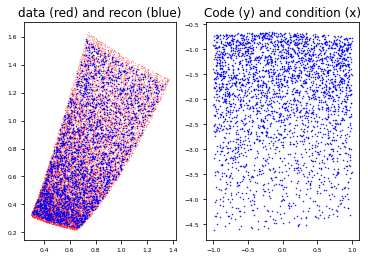

In [10]:
train()
test()
analyze_data()